In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Załaduj dane
data_xxx = pd.read_csv("C:/Users/kubaj/Desktop/Kod/Bolan/xxx.csv")

In [3]:
# Tworzenie kolumny 'DATE' ręcznie przez sformatowanie ciągu znaków i konwersję na datę. Ta metoda nie wyrzuca błedu
# Tworzymy nową kolumne z trzech juz istniejących kolumn, tak mamy kolumne która posiada date
data_xxx['DATE'] = (pd.to_datetime(data_xxx['YEAR'].astype(str) + '-' + data_xxx['MO'].astype(str) + '-' + data_xxx['DY'].astype(str)))

In [4]:
# Ustawienie 'DATE' jako indeksu DataFrame
data_xxx.set_index('DATE', inplace=True)

In [5]:
# Usuwamy nie potrzebne juz kolumny
data_xxx=data_xxx.drop(columns=['YEAR', 'MO', 'DY'])

In [6]:
# Usunięcie duplikatów, zachowanie pierwszego wystąpienia każdej daty
data_xxx = data_xxx[~data_xxx.index.duplicated(keep='first')]

In [7]:
# Ustawienie codziennej częstotliwości, aby zagwarantować kompletność danych
data_xxx = data_xxx.asfreq('D')
print(data_xxx.index.freq)

<Day>


In [8]:
# Identyfikacja i zastąpienie anomalii wartością NaN
data_xxx.loc[data_xxx['T2M'] < -100, 'T2M'] = None

In [9]:
# Wypełnienie brakujących wartości metodą 'backfill'
data_xxx['T2M'].fillna(method='bfill', inplace=True)

In [10]:
# Wyświetlanie danych
print(data_xxx.head())

             T2M
DATE            
1982-01-01  1.23
1982-01-02 -1.28
1982-01-03 -1.10
1982-01-04  0.94
1982-01-05  1.87


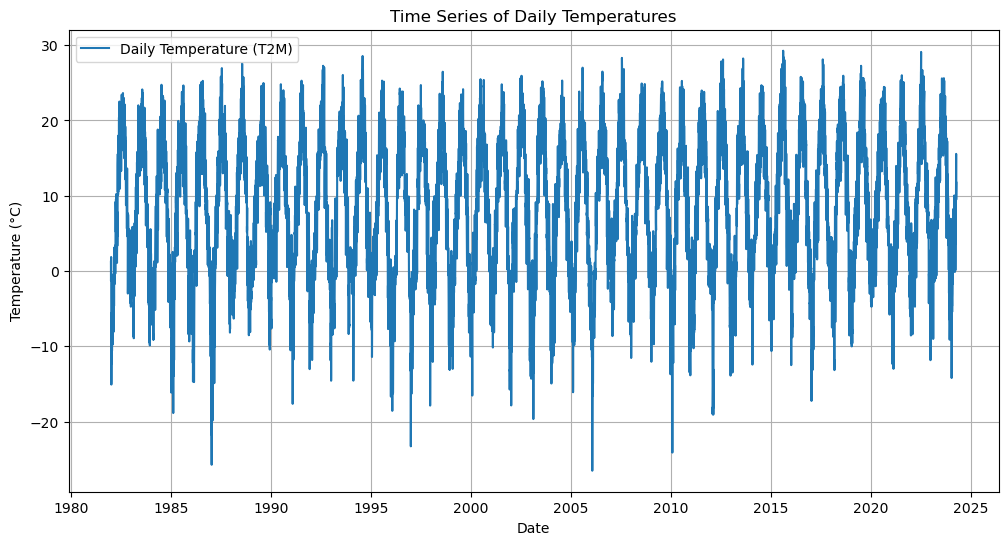

In [11]:
# Rysowanie wykresu serii czasowej temperatury
plt.figure(figsize=(12, 6))
plt.plot(data_xxx['T2M'], label='Daily Temperature (T2M)')
plt.title('Time Series of Daily Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Funkcja dzieląca dane na zestawy treningowe i testowe
def split_data(data, train_ratio):
    train_size = int(len(data) * train_ratio)
    train_set = data.iloc[:train_size]
    test_set = data.iloc[train_size:]
    return train_set, test_set

In [13]:
# Podziały na zestawy
splits = [0.35, 0.50, 0.65, 0.80]
datasets = {}

In [14]:
# Tworzenie zestawów train/test
for split in splits:
    train, test = split_data(data_xxx, split)
    datasets[f'train_{int(split*100)}'] = train
    datasets[f'test_{int(split*100)}'] = test

In [15]:
# Wyświetlanie przykładowych danych z zestawu treningowego i testowego dla podziału 35%/65%
# Należy pamiętać że liczba oznacza wielkosc czesci train
print("Przykładowe dane treningowe (35%):")
print(datasets['train_35'].tail())
print(len(datasets['train_35']))

print("\nPrzykładowe dane testowe (35%):")
print(datasets['test_35'].head())
print(len(datasets['test_35']))

Przykładowe dane treningowe (35%):
              T2M
DATE             
1996-10-12   7.52
1996-10-13   9.54
1996-10-14   9.89
1996-10-15   9.56
1996-10-16  12.90
5403

Przykładowe dane testowe (35%):
              T2M
DATE             
1996-10-17  12.67
1996-10-18  11.73
1996-10-19   9.30
1996-10-20   7.29
1996-10-21   5.76
10035


In [16]:
# Aby uniknąć SettingWithCopyWarning, upewnij się, że każdy z datasetów jest niezależnym DataFrame'em.
for key in datasets.keys():
    datasets[key] = datasets[key].copy()

# Następnie możesz bezpiecznie zastosować .loc do wypełnienia wartości NaN
for key in ['train_35', 'test_35', 'train_50', 'test_50', 'train_65', 'test_65', 'train_80', 'test_80']:
    datasets[key].loc[:, 'T2M'] = datasets[key]['T2M'].fillna(method='ffill')

Model AR

In [17]:
# Funkcja do znajdowania najlepszego modelu AR dla danego zestawu danych
def best_ar_model(data):
    best_aic = np.inf
    best_order = None
    best_model = None

    # Testujemy różne rzędy modelu AR
    for i in range(1, 5):  # Możesz zmienić zakres rzędów zgodnie z potrzebami
        try:
            model = AutoReg(data, lags=i)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = i
                best_model = results
        except Exception as e:
            print(f"Błąd podczas dopasowywania modelu AR({i}): {e}")
            continue

    return best_order, best_aic, best_model

In [18]:
# Funkcja do tworzenia modeli AR, prognozowania i wizualizacji
def plot_predictions(train_data, test_data, best_order):
    model = AutoReg(train_data, lags=best_order)
    model_fitted = model.fit()
    predictions = model_fitted.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(test_data.index, predictions, label='Predicted Test Data', color='red')
    plt.title('AR Model Predictions vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return predictions

In [19]:
# Funkcja sprawdzające dokładność modelu
def evaluate_forecast(actuals, predictions):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

In [20]:
# Wywołanie funkcji
order, aic, model = best_ar_model(datasets['train_35']['T2M'])
print(f"Najlepszy model AR dla zestawu treningowego (35%): AR({order}) z AIC = {aic}")

Najlepszy model AR dla zestawu treningowego (35%): AR(4) z AIC = 23570.08176089182


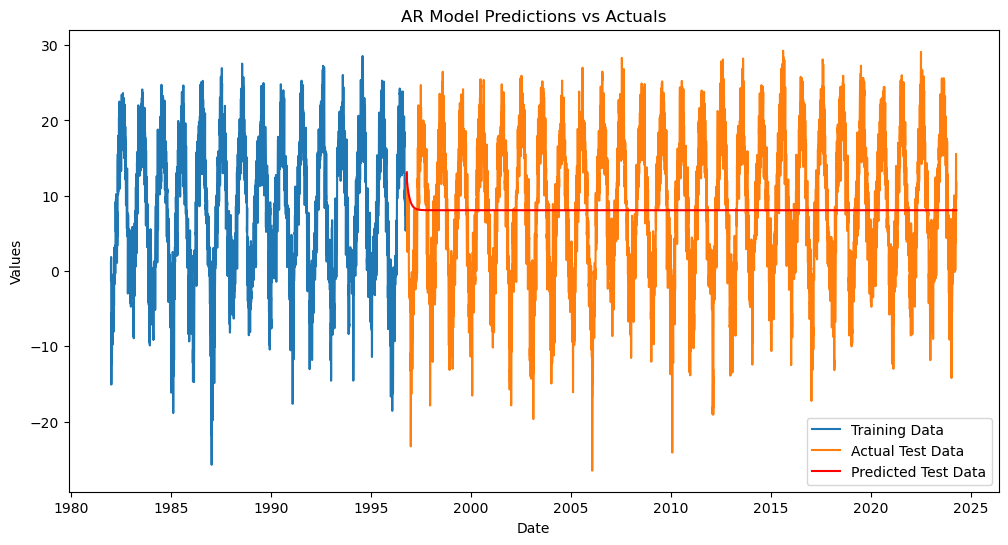

In [21]:
# Wywołanie funkcji dla każdego zestawu danych
predictions_35 = plot_predictions(datasets['train_35']['T2M'], datasets['test_35']['T2M'], 5)  # Użyj odpowiednich rzędów dla każdego zestawu

In [22]:
# Wywołanie funkcji oceny dla zestawu testowego 35%
evaluate_forecast(datasets['test_35']['T2M'], predictions_35)

Mean Squared Error: 87.50771879033086
Root Mean Squared Error: 9.354556044534174


In [23]:
order, aic, model = best_ar_model(datasets['train_50']['T2M'])
print(f"Najlepszy model AR dla zestawu treningowego (50%): AR({order}) z AIC = {aic}")

Najlepszy model AR dla zestawu treningowego (50%): AR(4) z AIC = 33782.59633032347


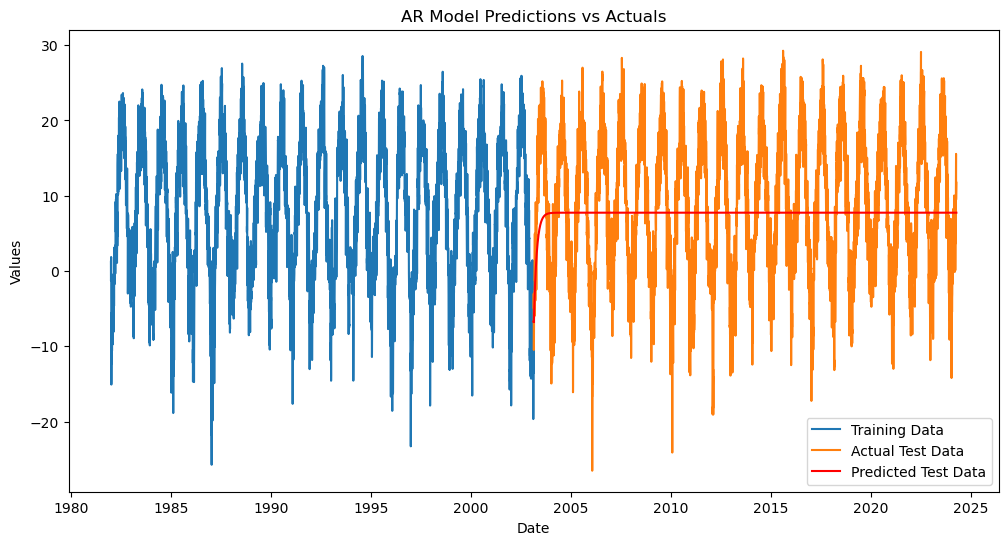

In [24]:
predictions_50 = plot_predictions(datasets['train_50']['T2M'], datasets['test_50']['T2M'], 5)

In [25]:
evaluate_forecast(datasets['test_50']['T2M'], predictions_50)

Mean Squared Error: 86.7682447371391
Root Mean Squared Error: 9.314947382413875


In [26]:
order, aic, model = best_ar_model(datasets['train_65']['T2M'])
print(f"Najlepszy model AR dla zestawu treningowego (65%): AR({order}) z AIC = {aic}")

Najlepszy model AR dla zestawu treningowego (65%): AR(4) z AIC = 43801.256765495404


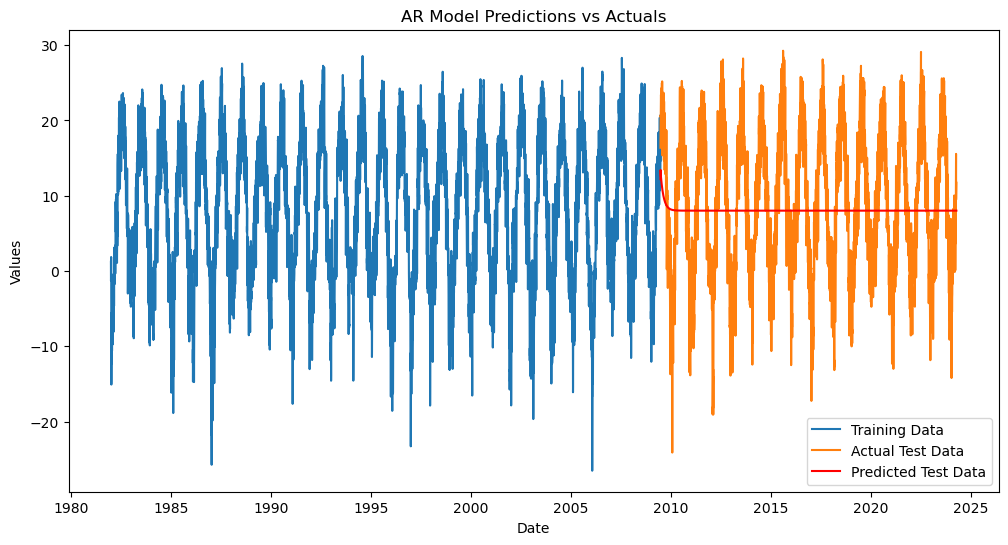

In [27]:
predictions_65 = plot_predictions(datasets['train_65']['T2M'], datasets['test_65']['T2M'], 5)

In [28]:
evaluate_forecast(datasets['test_65']['T2M'], predictions_65)

Mean Squared Error: 86.37048842746782
Root Mean Squared Error: 9.293572425470618


In [29]:
order, aic, model = best_ar_model(datasets['train_80']['T2M'])
print(f"Najlepszy model AR dla zestawu treningowego (80%): AR({order}) z AIC = {aic}")

Najlepszy model AR dla zestawu treningowego (80%): AR(4) z AIC = 53942.18591981623


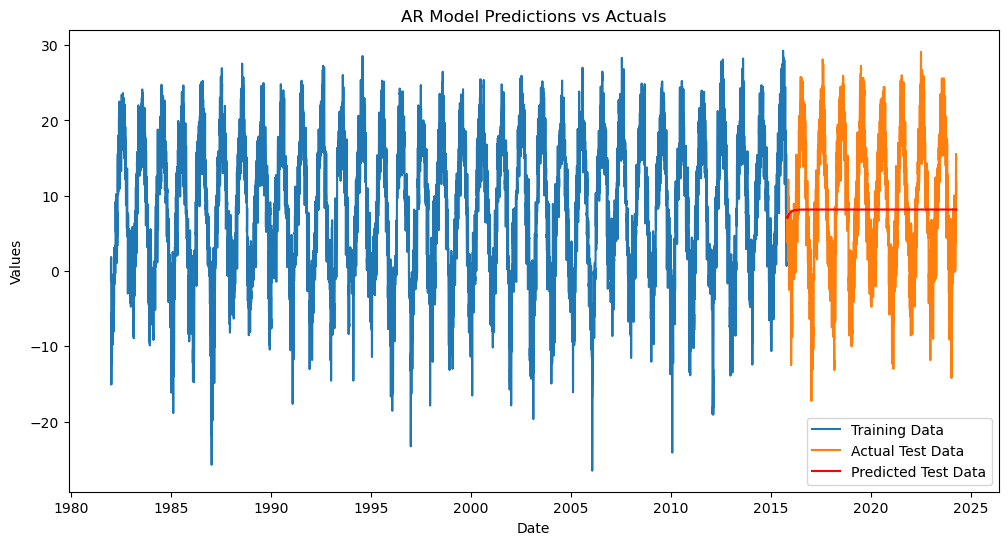

In [30]:
predictions_80 = plot_predictions(datasets['train_80']['T2M'], datasets['test_80']['T2M'], 5)

In [31]:
evaluate_forecast(datasets['test_80']['T2M'], predictions_80)

Mean Squared Error: 81.39212057363395
Root Mean Squared Error: 9.021758175302303


Model MA

In [32]:
# Funkcja do wybierania najlepszego modelu
def evaluate_ma_model(data, max_lag):
    best_aic = np.inf
    best_order = None
    best_model = None

    for q in range(1, max_lag+1):
        try:
            # Specyfikacja modelu MA(q) z dodatkowymi ustawieniami początkowymi
            model = ARIMA(data, order=(0, 0, q), enforce_stationarity=False, enforce_invertibility=True)
            results = model.fit(method='innovations_mle', low_memory=True)  # Metoda innovations MLE może być bardziej stabilna
            if results.aic < best_aic and np.all(np.abs(results.maparams) < 1):  # Dodatkowa weryfikacja odwracalności
                best_aic = results.aic
                best_order = q
                best_model = results
        except Exception as e:
            print(f"Failed to fit MA({q}) model: {e}")
            continue

    return best_order, best_aic, best_model

In [33]:
# Funkcja do wizualizacji i oceny modelu
def plot_and_evaluate(model, train_data, test_data, order):
    # Prognozowanie
    start = len(train_data)
    end = start + len(test_data) - 1
    predictions = model.predict(start=start, end=end)

    # Wizualizacja
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(test_data.index, predictions, label='Predicted Test Data', color='red')
    plt.title(f'MA({order}) Predictions vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Obliczanie i drukowanie błędów
    mse = mean_squared_error(test_data, predictions)
    rmse = sqrt(mse)
    print(f"Mean Squared Error for MA({order}): {mse}")
    print(f"Root Mean Squared Error for MA({order}): {rmse}")

In [34]:
order, aic, model = evaluate_ma_model(datasets['train_35']['T2M'], max_lag=10)
if model is not None:
    print(f"Best MA model: MA({order}) with AIC: {aic}")
else:
    print("No invertible and stable MA model found within the given range.")

Best MA model: MA(1) with AIC: 33274.469981312075


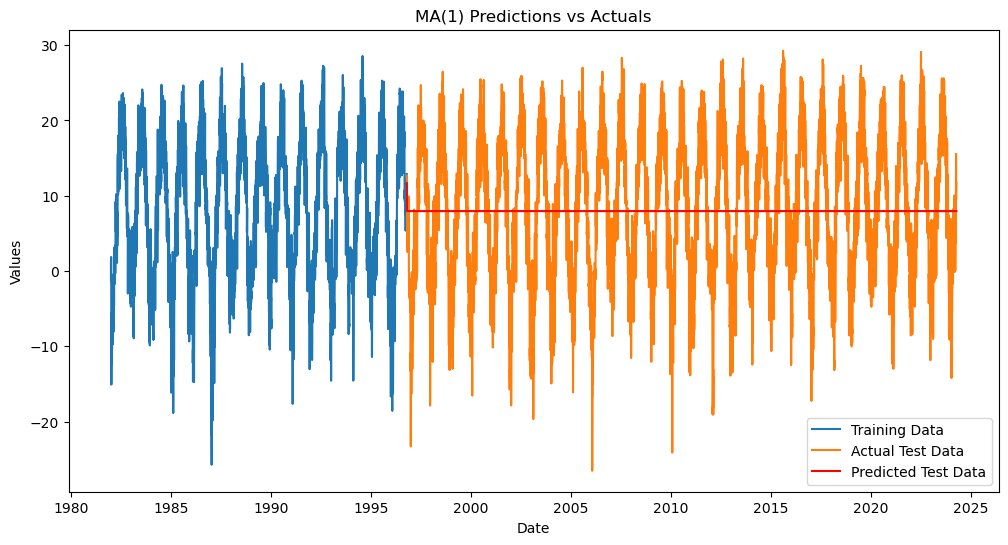

Mean Squared Error for MA(1): 87.28828652189473
Root Mean Squared Error for MA(1): 9.34282005188448


In [35]:
# Wywołanie funkcji wizualizacji dla najlepszego modelu
plot_and_evaluate(model, datasets['train_35']['T2M'], datasets['test_35']['T2M'], 1)

In [36]:
order, aic, model = evaluate_ma_model(datasets['train_50']['T2M'], max_lag=10)
if model is not None:
    print(f"Best MA model: MA({order}) with AIC: {aic}")
else:
    print("No invertible and stable MA model found within the given range.")

Best MA model: MA(1) with AIC: 47675.260512889356


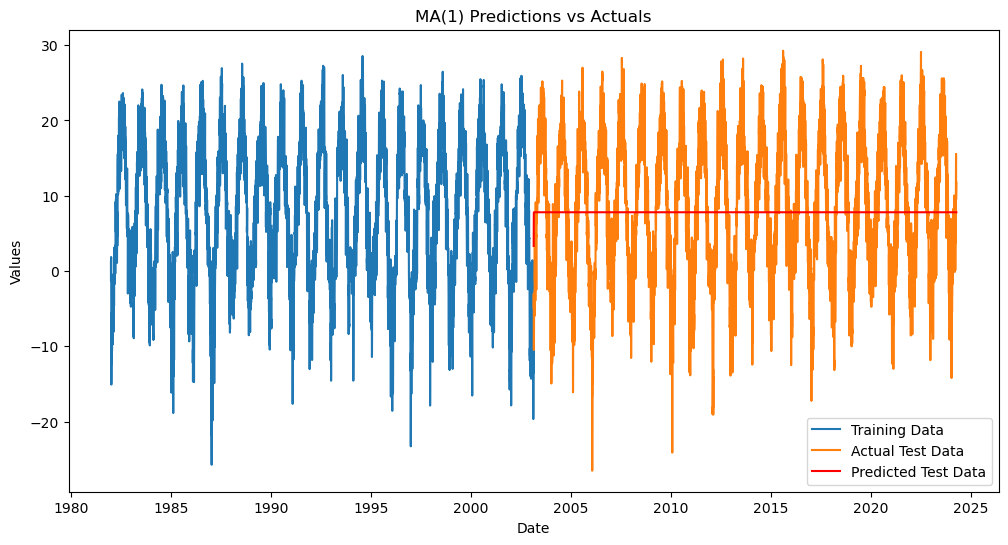

Mean Squared Error for MA(1): 86.51826765558766
Root Mean Squared Error for MA(1): 9.30151964227285


In [37]:
plot_and_evaluate(model, datasets['train_50']['T2M'], datasets['test_50']['T2M'], 1)

In [38]:
order, aic, model = evaluate_ma_model(datasets['train_65']['T2M'], max_lag=10)
if model is not None:
    print(f"Best MA model: MA({order}) with AIC: {aic}")
else:
    print("No invertible and stable MA model found within the given range.")

Best MA model: MA(1) with AIC: 61882.17541845229


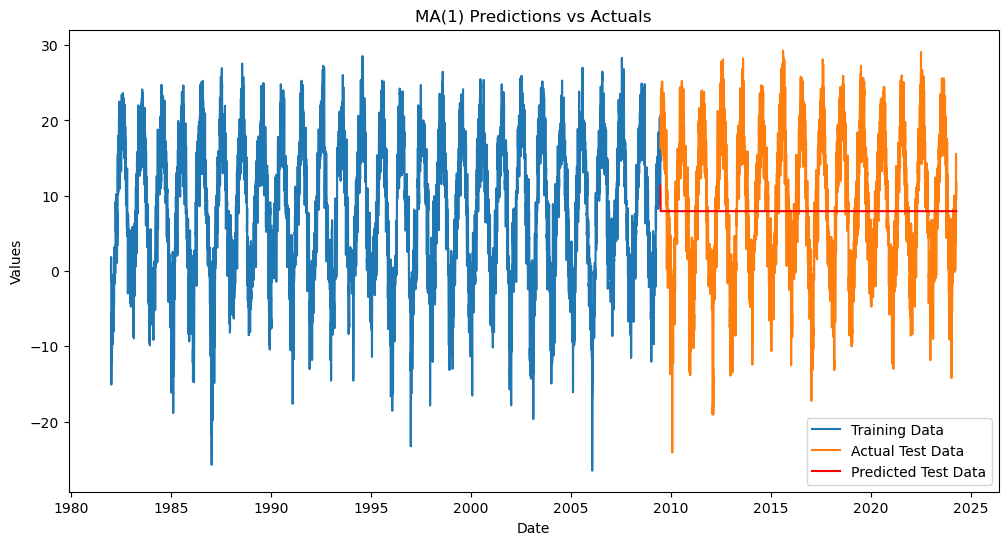

Mean Squared Error for MA(1): 87.32347285999485
Root Mean Squared Error for MA(1): 9.344702930537432


In [39]:
plot_and_evaluate(model, datasets['train_65']['T2M'], datasets['test_65']['T2M'], 1)

In [40]:
order, aic, model = evaluate_ma_model(datasets['train_80']['T2M'], max_lag=10)
if model is not None:
    print(f"Best MA model: MA({order}) with AIC: {aic}")
else:
    print("No invertible and stable MA model found within the given range.")

Best MA model: MA(1) with AIC: 76326.83729757601


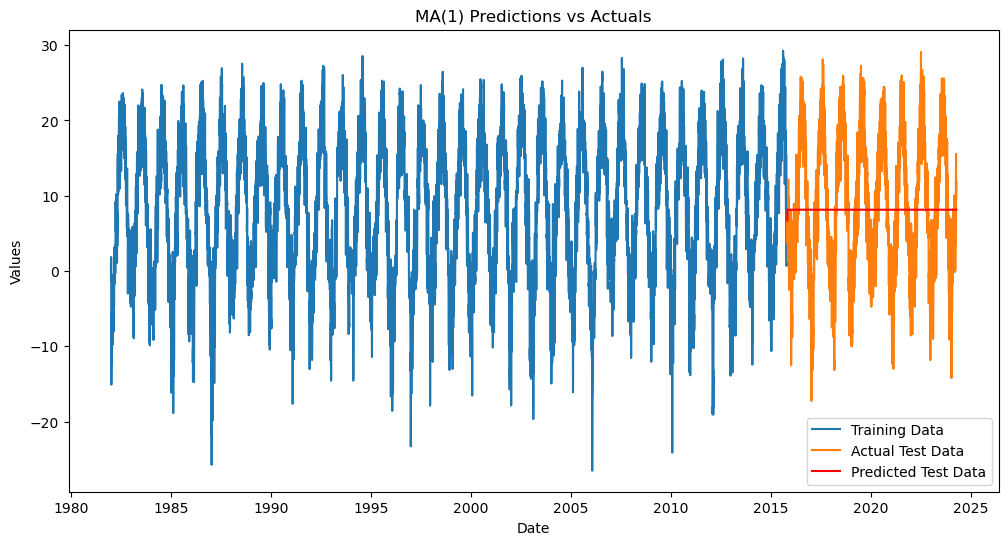

Mean Squared Error for MA(1): 81.61005887587656
Root Mean Squared Error for MA(1): 9.033828583489758


In [41]:
plot_and_evaluate(model, datasets['train_80']['T2M'], datasets['test_80']['T2M'], 1)

Model ARIMA

In [42]:
# Funkcja do wybierania najlepszego modelu
def find_best_arima(train_data, seasonal=False):
    # Użycie auto_arima do automatycznego znalezienia najlepszego modelu ARIMA
    arima_model = auto_arima(train_data, seasonal=seasonal, trace=True, suppress_warnings=True, stepwise=True)
    return arima_model

In [43]:
# Funkcja do wizualizacji i sprawzenia modelu
def plot_and_evaluate_arima(model, train_data, test_data):
    # Prognozowanie
    predictions = model.predict(n_periods=len(test_data))

    # Wizualizacja
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(test_data.index, predictions, label='Predicted Test Data', color='red')
    plt.title('ARIMA Predictions vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Obliczanie i drukowanie błędów
    mse = mean_squared_error(test_data, predictions)
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

In [44]:
# Znalezienie najlepszego modelu ARIMA dla zestawu danych train_35
model_arima_35 = find_best_arima(datasets['train_35']['T2M'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=23489.937, Time=1.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42367.746, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=23963.773, Time=0.57 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35947.998, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=23677.311, Time=1.72 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=23778.561, Time=2.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=23490.400, Time=2.45 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=23489.906, Time=5.46 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=23550.011, Time=2.61 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=23493.559, Time=4.92 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=23491.032, Time=2.97 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=23518.301, Time=4.05 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=23492.270, Time=3.39 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=23482.444, Time=9.67 sec
 ARIMA(1,0,3)(0,0,0

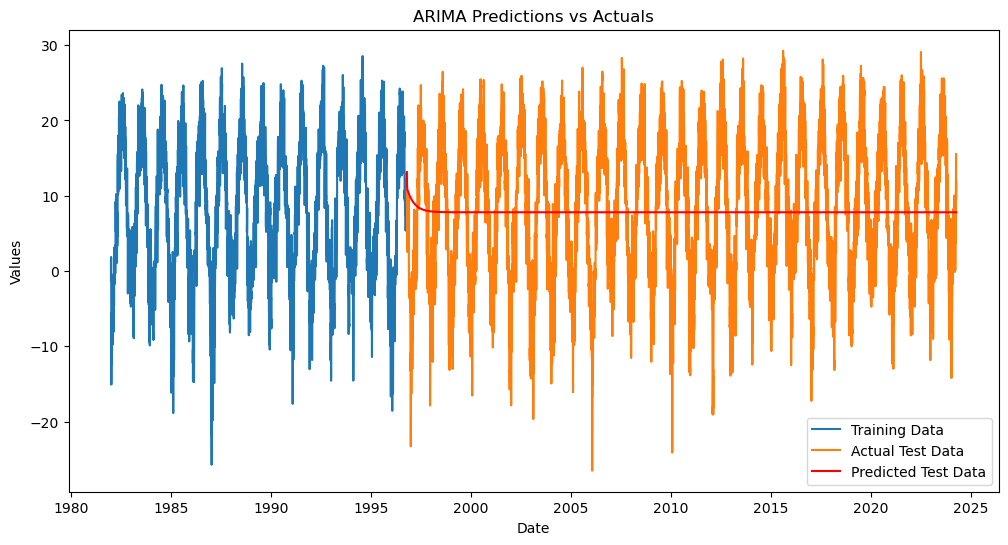

Mean Squared Error: 87.99965965288764
Root Mean Squared Error: 9.380813379067279


In [45]:
# Wywołanie funkcji wizualizacji dla modelu ARIMA
plot_and_evaluate_arima(model_arima_35, datasets['train_35']['T2M'], datasets['test_35']['T2M'])

In [46]:
model_arima_50 = find_best_arima(datasets['train_50']['T2M'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=33652.469, Time=2.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=60483.708, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=34349.576, Time=0.72 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51325.482, Time=1.32 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=33933.933, Time=2.50 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=34066.676, Time=3.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=33648.512, Time=3.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=33679.907, Time=5.02 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=33681.550, Time=11.54 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=33644.496, Time=9.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=33647.496, Time=7.41 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=33646.686, Time=8.06 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=33650.695, Time=4.36 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=33648.670, Time=2.44 sec
 ARIMA(4,0,4)(0,0,

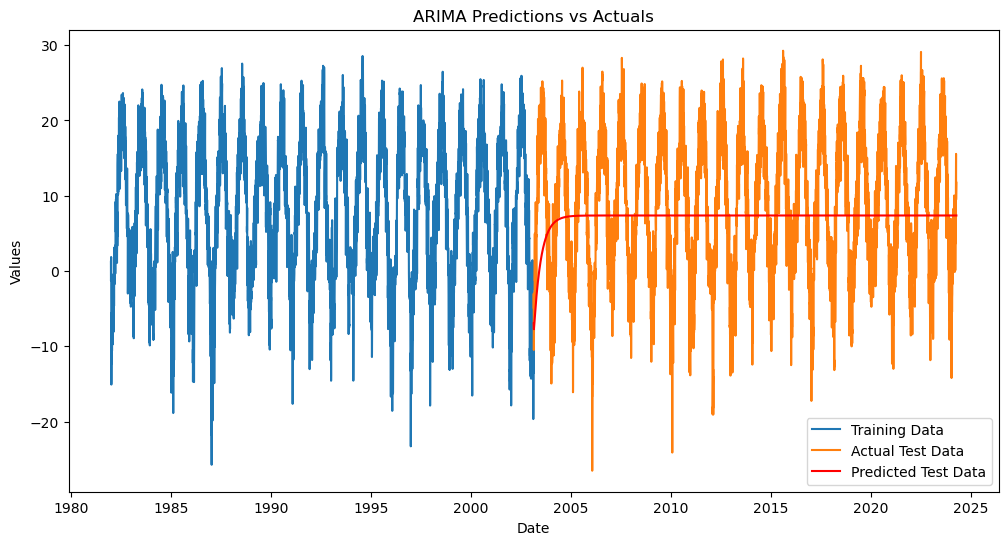

Mean Squared Error: 90.27476450252745
Root Mean Squared Error: 9.501303305469595


In [47]:
plot_and_evaluate_arima(model_arima_50, datasets['train_50']['T2M'], datasets['test_50']['T2M'])

In [48]:
model_arima_65 = find_best_arima(datasets['train_65']['T2M'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=43631.142, Time=6.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=78726.217, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=44521.277, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=66797.797, Time=1.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=43985.832, Time=2.99 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=44170.754, Time=3.91 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=43629.833, Time=3.72 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=43673.955, Time=7.24 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=43675.712, Time=14.70 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=43628.396, Time=3.87 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=43629.311, Time=9.68 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=43629.691, Time=9.35 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=43630.791, Time=6.18 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=43630.011, Time=6.76 sec
 ARIMA(4,0,4)(0,0,

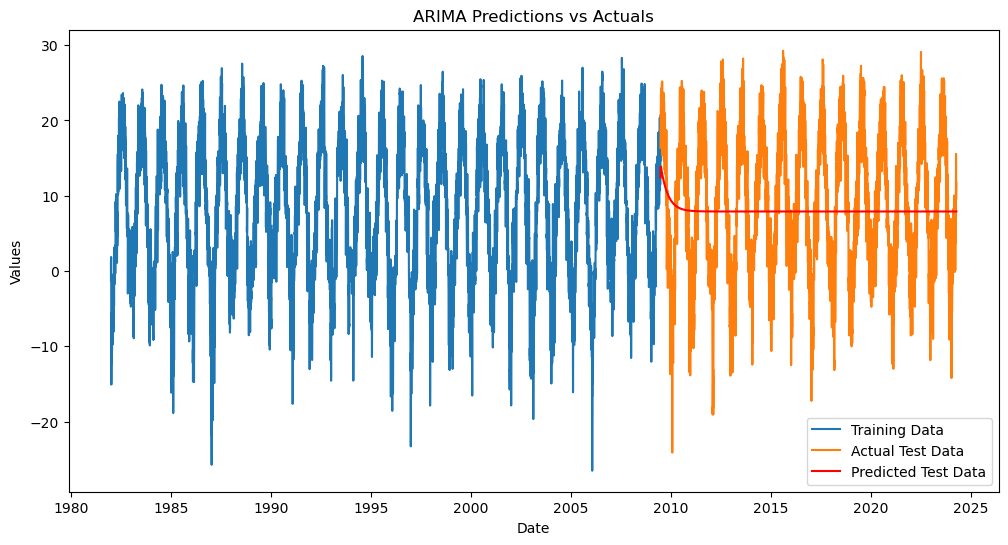

Mean Squared Error: 86.65459484346869
Root Mean Squared Error: 9.3088449790223


In [49]:
plot_and_evaluate_arima(model_arima_65, datasets['train_65']['T2M'], datasets['test_65']['T2M'])

In [50]:
model_arima_80 = find_best_arima(datasets['train_80']['T2M'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=53723.442, Time=3.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97271.237, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=54798.284, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=82528.534, Time=2.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=54148.683, Time=3.87 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=54352.221, Time=5.42 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=53719.793, Time=11.73 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=53775.746, Time=8.48 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=53776.706, Time=17.67 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=53718.682, Time=8.27 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=53719.630, Time=11.69 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=53720.372, Time=11.08 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=53722.489, Time=6.47 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=53721.235, Time=7.03 sec
 ARIMA(4,0,4)(0

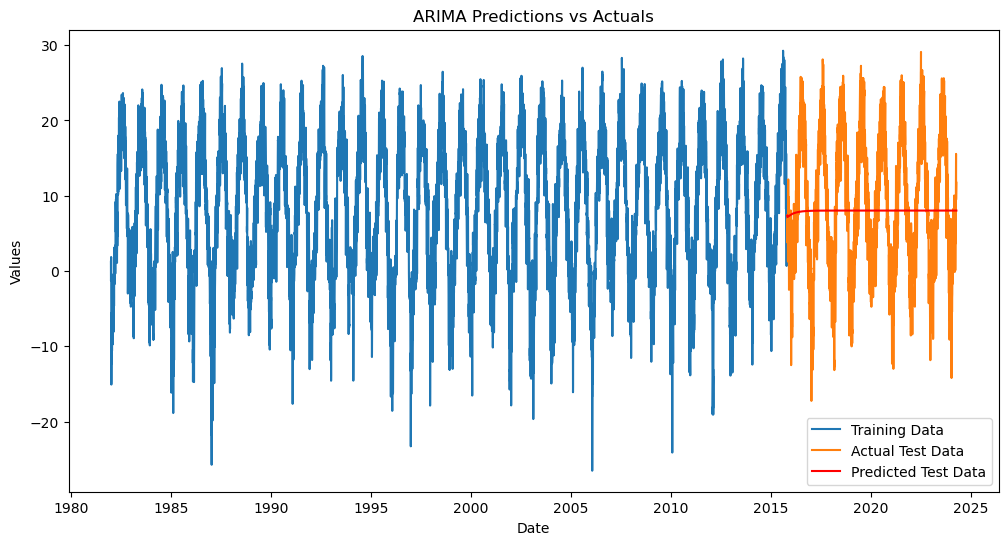

Mean Squared Error: 81.61442435020686
Root Mean Squared Error: 9.034070198432534


In [51]:
plot_and_evaluate_arima(model_arima_80, datasets['train_80']['T2M'], datasets['test_80']['T2M'])

Model SARIMA

Próba użycia modelu SARIMA skończyła się niepowodzeniem. Model dla najmniejszego zestawu train miał wielkość 5 GB.
Jest to zdecydowanie za dużo.

In [52]:
# # Określenie parametrów
# order = (1, 0, 1)  # Parametry niesezonowe: (p, d, q)
# seasonal_order = (1, 0, 1, 365)  # Parametry sezonowe: (P, D, Q, S)

# # Załóżmy, że masz już wcześniej przygotowane i podzielone dane: datasets['train_35'] i datasets['test_35']
# fit_and_forecast_sarima(datasets['train_35']['T2M'], datasets['test_35']['T2M'], order, seasonal_order)

Facebook Prophet

In [53]:
def forecast_with_prophet(train_data, test_data):
    # Przygotowywanie danych dla Prophet
    train_data_reset = train_data.reset_index()
    prophet_train = train_data_reset.rename(columns={'DATE': 'ds', 'T2M': 'y'})
    
    # Tworzenie modelu Prophet
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(prophet_train)

    # Tworzenie dataframe'u dl wyników
    future_dates = model.make_future_dataframe(periods=len(test_data), freq='D')
    
    # Forecast
    forecast = model.predict(future_dates)
    forecast_filtered = forecast[['ds', 'yhat']].tail(len(test_data))
    
    return forecast_filtered.set_index('ds'), model

In [54]:
def plot_and_evaluate_prophet(train_data, test_data, forecast):
    # Wizualizacja
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Actual Test Data')
    plt.plot(forecast.index, forecast['yhat'], label='Predicted Test Data', color='red')
    plt.title('Prophet Model Predictions vs Actuals')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Ocena dokładności forcastu
    mse = mean_squared_error(test_data, forecast['yhat'])
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

00:23:30 - cmdstanpy - INFO - Chain [1] start processing
00:23:31 - cmdstanpy - INFO - Chain [1] done processing


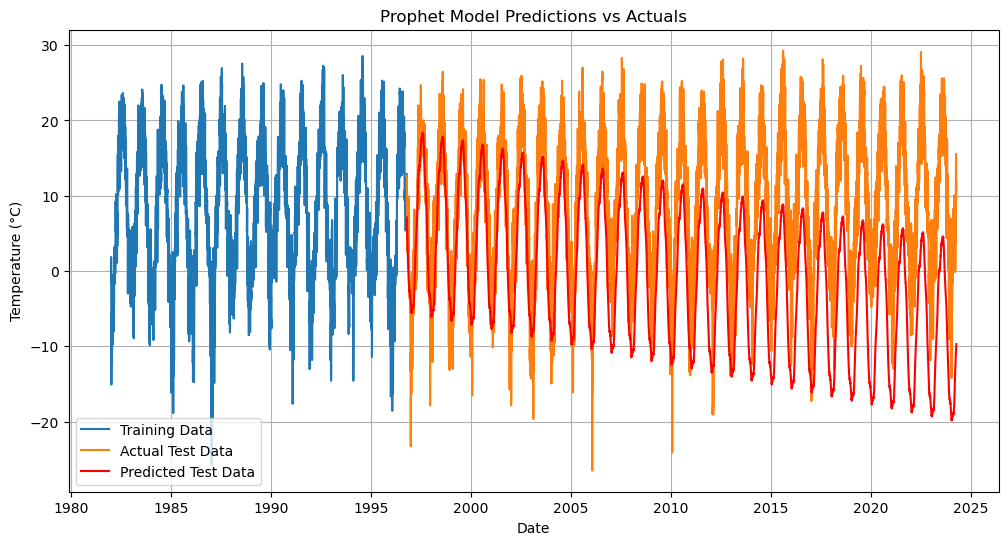

Mean Squared Error: 125.76875103264008
Root Mean Squared Error: 11.214666782060004


In [55]:
forecast_result, model_prophet = forecast_with_prophet(datasets['train_35']['T2M'], datasets['test_35']['T2M'])
plot_and_evaluate_prophet(datasets['train_35']['T2M'], datasets['test_35']['T2M'], forecast_result)

00:23:42 - cmdstanpy - INFO - Chain [1] start processing
00:23:43 - cmdstanpy - INFO - Chain [1] done processing


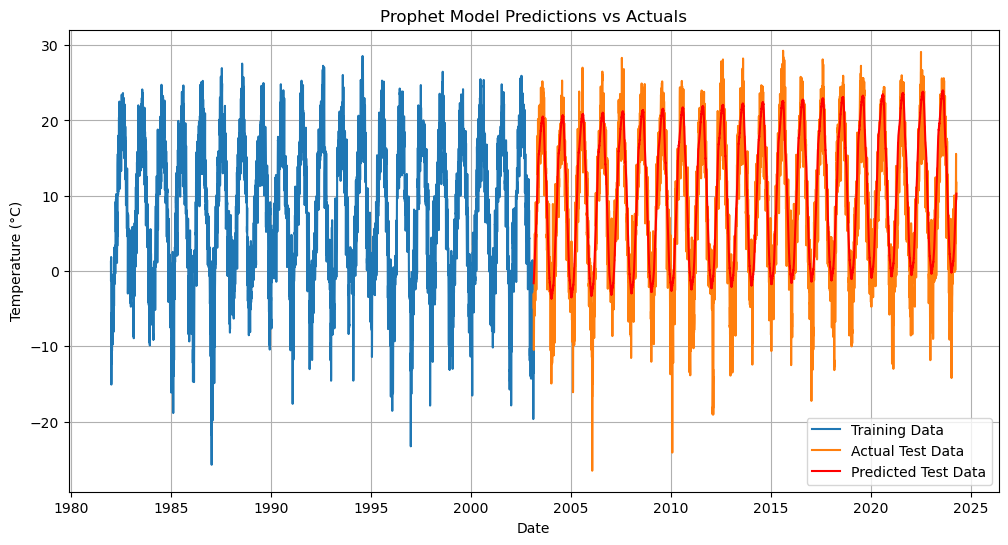

Mean Squared Error: 17.080908152091627
Root Mean Squared Error: 4.1329055338939975


In [56]:
forecast_result, model_prophet = forecast_with_prophet(datasets['train_50']['T2M'], datasets['test_50']['T2M'])
plot_and_evaluate_prophet(datasets['train_50']['T2M'], datasets['test_50']['T2M'], forecast_result)

00:23:53 - cmdstanpy - INFO - Chain [1] start processing
00:23:56 - cmdstanpy - INFO - Chain [1] done processing


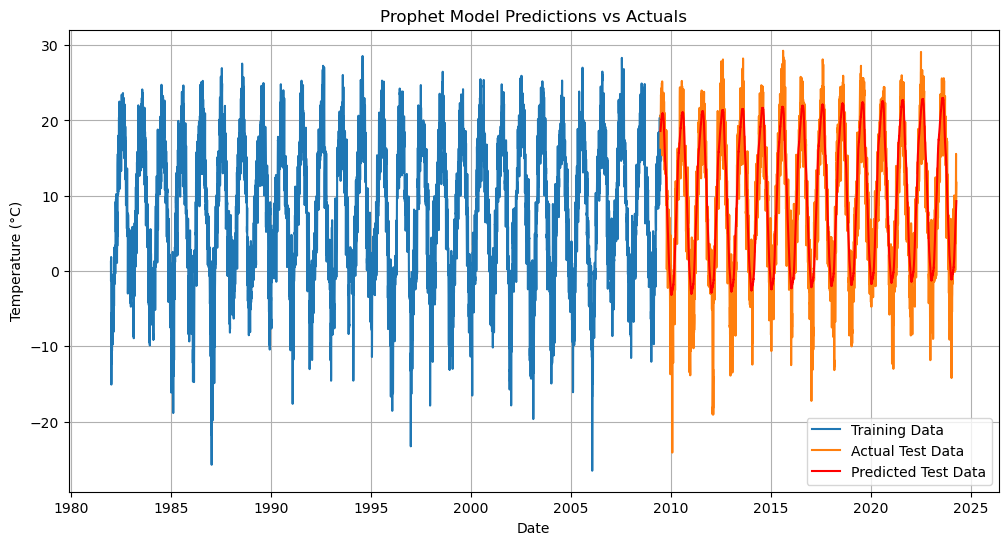

Mean Squared Error: 15.801860225983248
Root Mean Squared Error: 3.9751553713010073


In [57]:
forecast_result, model_prophet = forecast_with_prophet(datasets['train_65']['T2M'], datasets['test_65']['T2M'])
plot_and_evaluate_prophet(datasets['train_65']['T2M'], datasets['test_65']['T2M'], forecast_result)

00:24:07 - cmdstanpy - INFO - Chain [1] start processing
00:24:09 - cmdstanpy - INFO - Chain [1] done processing


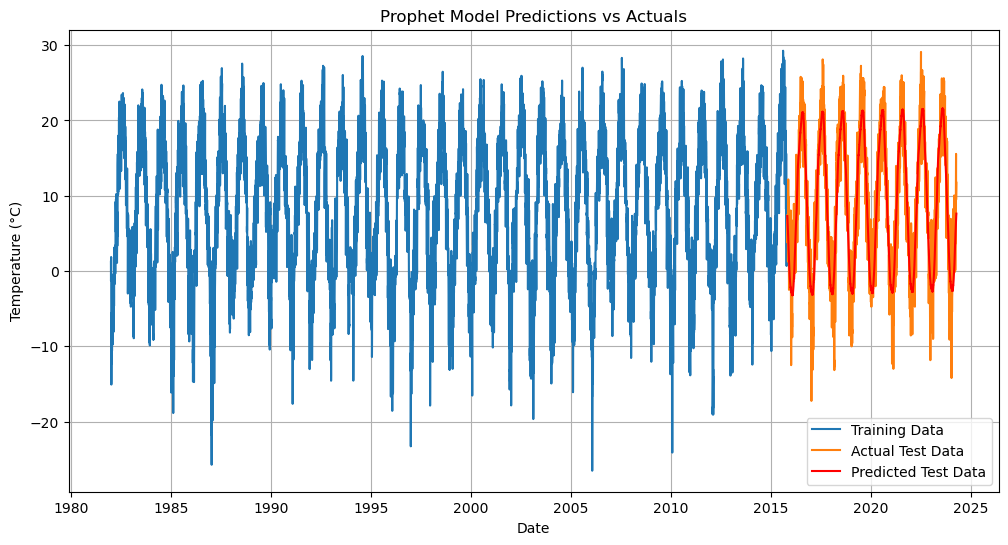

Mean Squared Error: 13.560817368413813
Root Mean Squared Error: 3.6825015096281786


In [58]:
forecast_result, model_prophet = forecast_with_prophet(datasets['train_80']['T2M'], datasets['test_80']['T2M'])
plot_and_evaluate_prophet(datasets['train_80']['T2M'], datasets['test_80']['T2M'], forecast_result)

Regresje Przygotowywanie Danych

In [59]:
# Przygotowanie danych dla regresji liniowej
data_lin_trend = data_xxx.copy()
data_lin_trend['Time'] = np.arange(len(data_lin_trend.index))
data_lin_trend['T2M'].interpolate(method='linear', inplace=True)

# Model regresji liniowej
model_lin = LinearRegression()
model_lin.fit(data_lin_trend['Time'].values.reshape(-1, 1), data_lin_trend['T2M'].values.reshape(-1, 1))
data_lin_trend['Trend_Linear'] = model_lin.predict(data_lin_trend['Time'].values.reshape(-1, 1))

# Wyodrębnienie danych trendu
data_lin_trend = data_lin_trend[['Trend_Linear']]

In [60]:
# Interpolacja danych
data_seasonal_trend = data_xxx.copy()
data_seasonal_trend['T2M'].interpolate(method='linear', inplace=True)

# Dekompozycja sezonowa
decomposition = seasonal_decompose(data_seasonal_trend['T2M'], model='additive', period=365)
data_seasonal_trend['Trend_Seasonal'] = decomposition.trend

# Wyodrębnienie danych trendu
data_seasonal_trend = data_seasonal_trend[['Trend_Seasonal']].dropna()

In [61]:
def split_data(data, train_ratio):
    train_size = int(len(data) * train_ratio)
    train_set = data.iloc[:train_size]
    test_set = data.iloc[train_size:]
    return train_set, test_set

splits = [0.35, 0.50, 0.65, 0.80]
datasets_lin = {}
datasets_seasonal = {}

for split in splits:
    train, test = split_data(data_lin_trend, split)
    datasets_lin[f'train_{int(split*100)}'], datasets_lin[f'test_{int(split*100)}'] = train, test
    train, test = split_data(data_seasonal_trend, split)
    datasets_seasonal[f'train_{int(split*100)}'], datasets_seasonal[f'test_{int(split*100)}'] = train, test

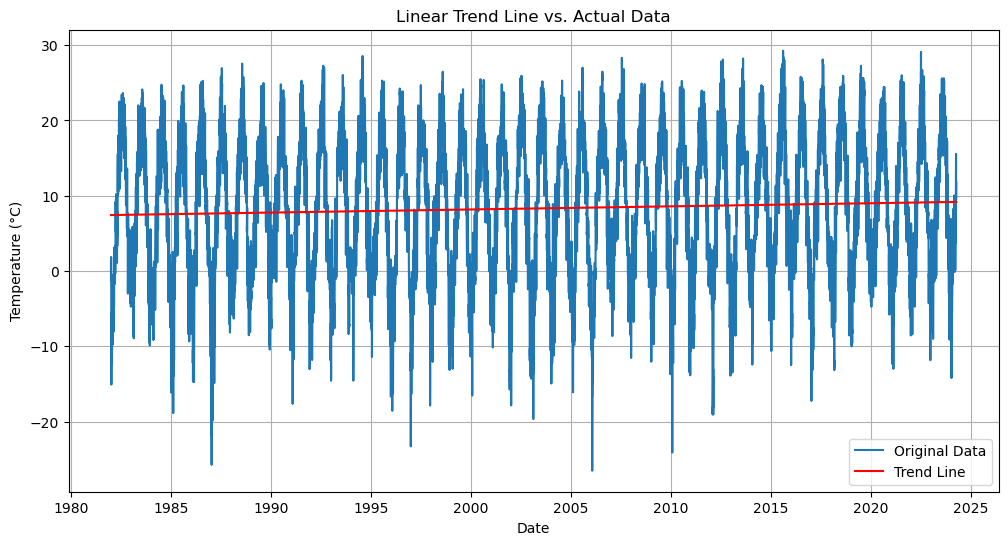

In [62]:
# Wizualizacja danych z wartościami oryginalnymi
plt.figure(figsize=(12, 6))
plt.plot(data_xxx.index, data_xxx['T2M'], label='Original Data')
plt.plot(data_lin_trend.index, data_lin_trend['Trend_Linear'], label='Trend Line', color='red')
plt.title('Linear Trend Line vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

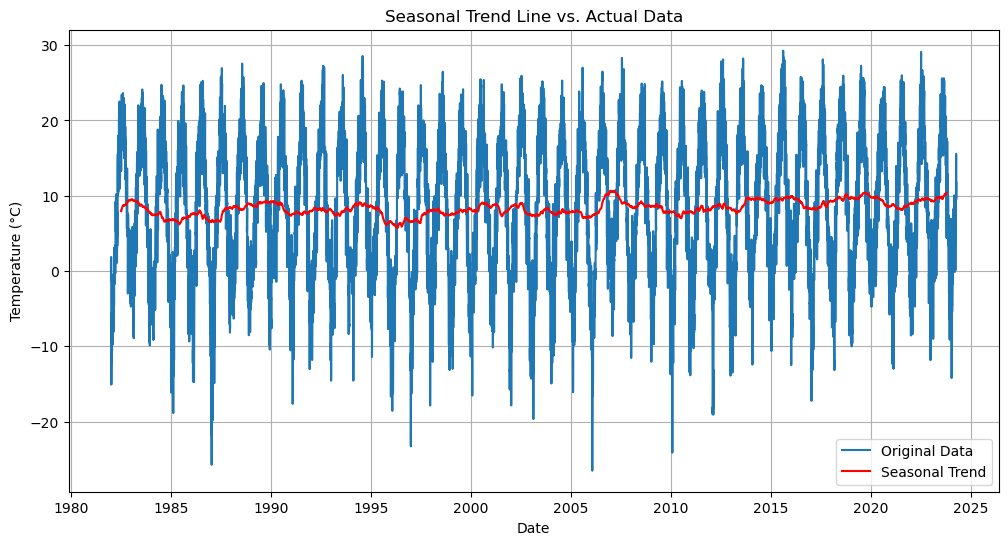

In [63]:
# Wizualizacja danych z wartościami oryginalnymi
plt.figure(figsize=(12, 6))
plt.plot(data_xxx.index, data_xxx['T2M'], label='Original Data')
plt.plot(data_seasonal_trend.index, data_seasonal_trend['Trend_Seasonal'], label='Seasonal Trend', color='red')
plt.title('Seasonal Trend Line vs. Actual Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

Model AR

In [64]:
def plot_predictions(train_data, test_data, model_fitted, original_data, title='AR Model Predictions vs Actuals'):
    plt.figure(figsize=(14, 7))
    # Dodajemy dane oryginalne do wykresu
    plt.plot(original_data.index, original_data, label='Original Data', color='grey', alpha=0.5)
    
    # Wykres dla danych treningowych
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    
    # Wykres dla danych testowych
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    
    # Generowanie przewidywań dla danych testowych
    predictions = model_fitted.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=False)
    
    # Dodanie przewidywań do wykresu
    plt.plot(test_data.index, predictions, label='Predicted Test Data', color='red')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    return predictions  # Zwracamy przewidywania do dalszej ewaluacji


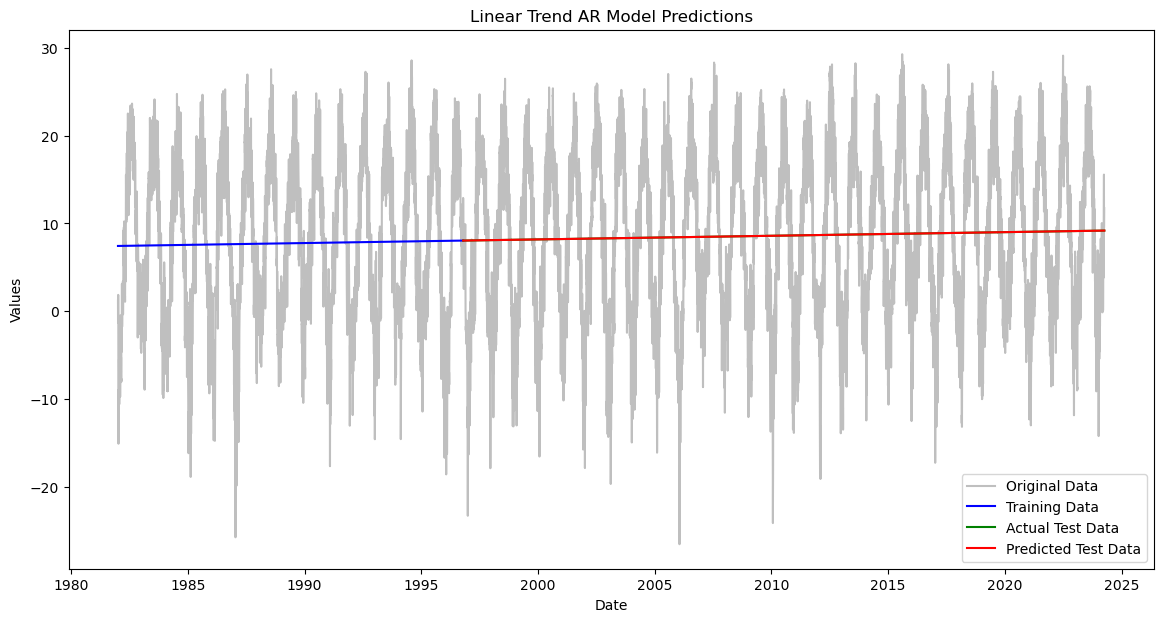

Mean Squared Error: 2.0163323664020367e-23
Root Mean Squared Error: 4.490358968280862e-12


In [65]:
# Model AR dla danych liniowego trendu
order_lin, aic_lin, model_lin = best_ar_model(datasets_lin['train_35']['Trend_Linear'])
predictions_lin = plot_predictions(datasets_lin['train_35']['Trend_Linear'], datasets_lin['test_35']['Trend_Linear'], model_lin, data_xxx['T2M'], title='Linear Trend AR Model Predictions')
evaluate_forecast(datasets_lin['test_35']['Trend_Linear'], predictions_lin)

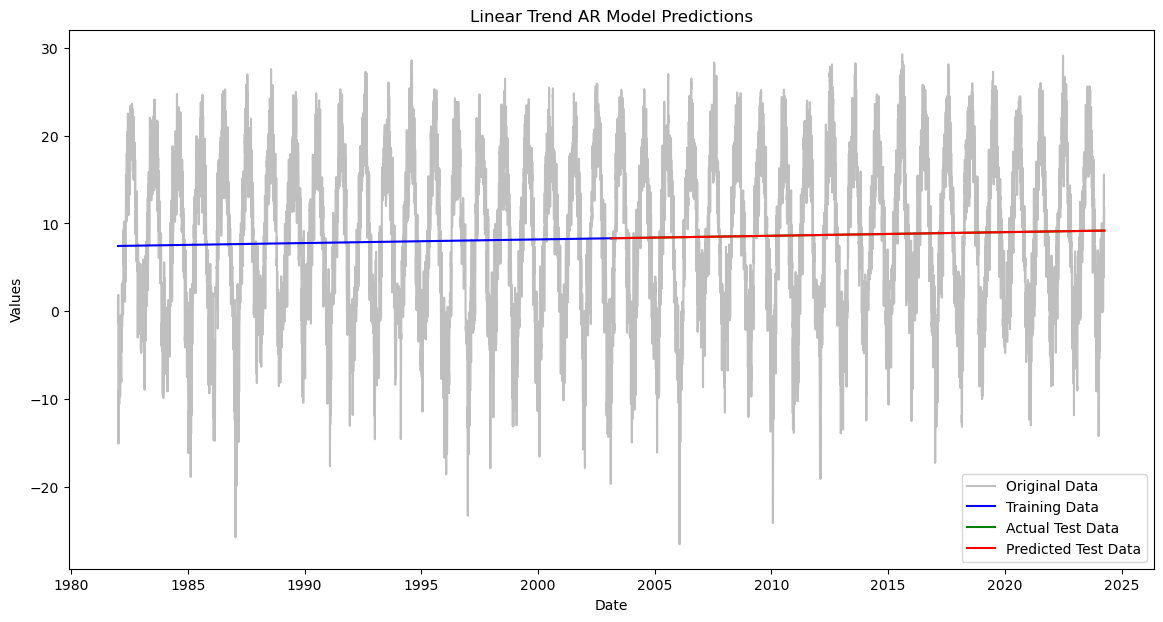

Mean Squared Error: 9.307317197656143e-22
Root Mean Squared Error: 3.050789602325297e-11


In [66]:
# Model AR dla danych liniowego trendu
order_lin, aic_lin, model_lin = best_ar_model(datasets_lin['train_50']['Trend_Linear'])
predictions_lin = plot_predictions(datasets_lin['train_50']['Trend_Linear'], datasets_lin['test_50']['Trend_Linear'], model_lin, data_xxx['T2M'], title='Linear Trend AR Model Predictions')
evaluate_forecast(datasets_lin['test_50']['Trend_Linear'], predictions_lin)

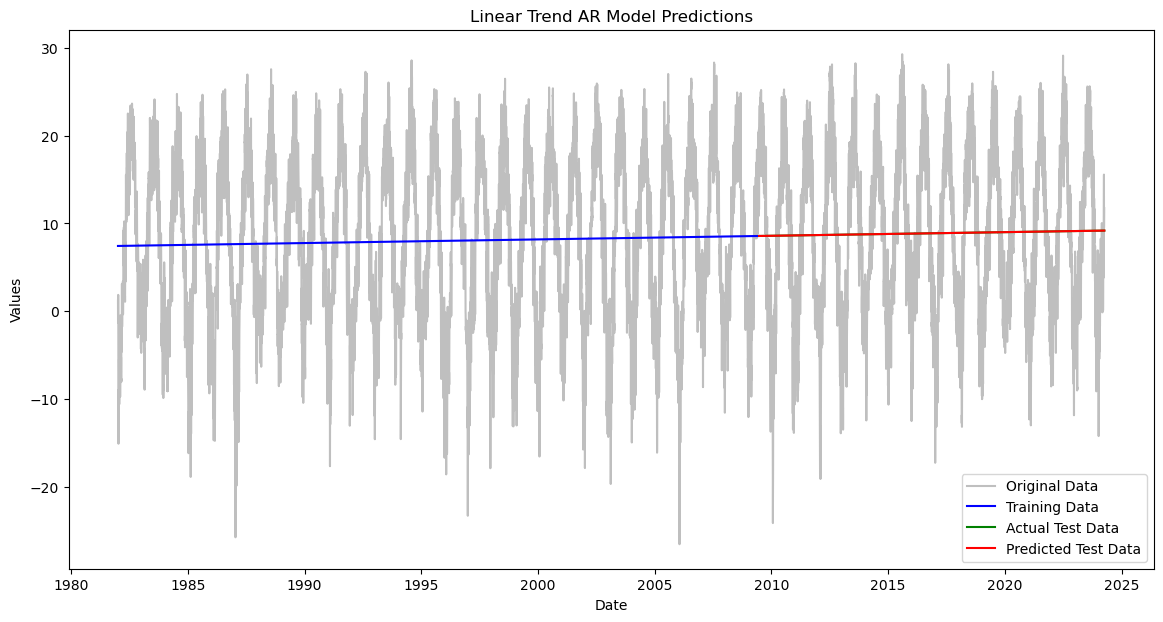

Mean Squared Error: 7.156536491829309e-25
Root Mean Squared Error: 8.459631488326965e-13


In [67]:
# Model AR dla danych liniowego trendu
order_lin, aic_lin, model_lin = best_ar_model(datasets_lin['train_65']['Trend_Linear'])
predictions_lin = plot_predictions(datasets_lin['train_65']['Trend_Linear'], datasets_lin['test_65']['Trend_Linear'], model_lin, data_xxx['T2M'], title='Linear Trend AR Model Predictions')
evaluate_forecast(datasets_lin['test_65']['Trend_Linear'], predictions_lin)

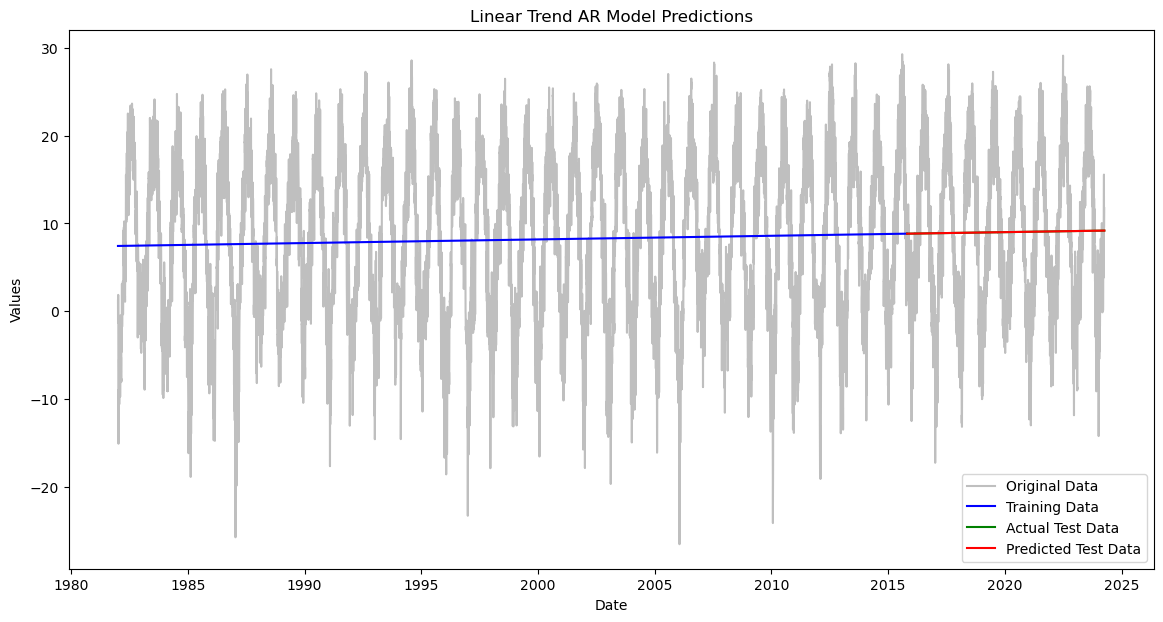

Mean Squared Error: 2.60951462838303e-25
Root Mean Squared Error: 5.10834085431173e-13


In [68]:
# Model AR dla danych liniowego trendu
order_lin, aic_lin, model_lin = best_ar_model(datasets_lin['train_80']['Trend_Linear'])
predictions_lin = plot_predictions(datasets_lin['train_80']['Trend_Linear'], datasets_lin['test_80']['Trend_Linear'], model_lin, data_xxx['T2M'], title='Linear Trend AR Model Predictions')
evaluate_forecast(datasets_lin['test_80']['Trend_Linear'], predictions_lin)

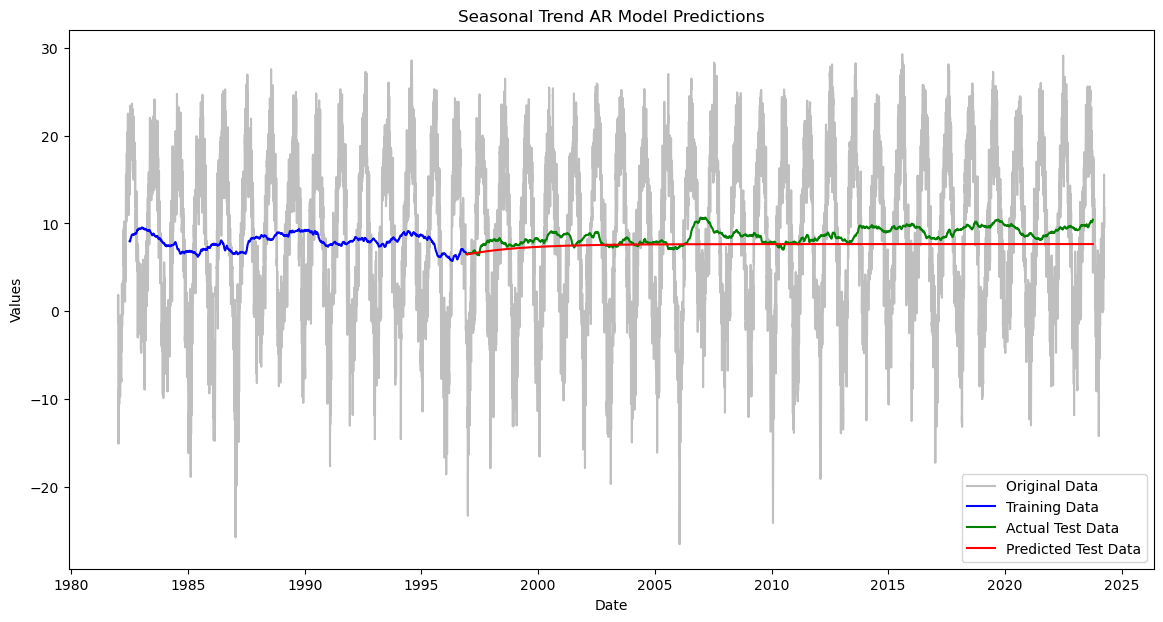

Mean Squared Error: 1.7191782247186445
Root Mean Squared Error: 1.3111743685409063


In [69]:
# Model AR dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_seasonal = best_ar_model(datasets_seasonal['train_35']['Trend_Seasonal'])
predictions_seasonal = plot_predictions(datasets_seasonal['train_35']['Trend_Seasonal'], datasets_seasonal['test_35']['Trend_Seasonal'], model_seasonal, data_xxx['T2M'], title='Seasonal Trend AR Model Predictions')
evaluate_forecast(datasets_seasonal['test_35']['Trend_Seasonal'], predictions_seasonal)

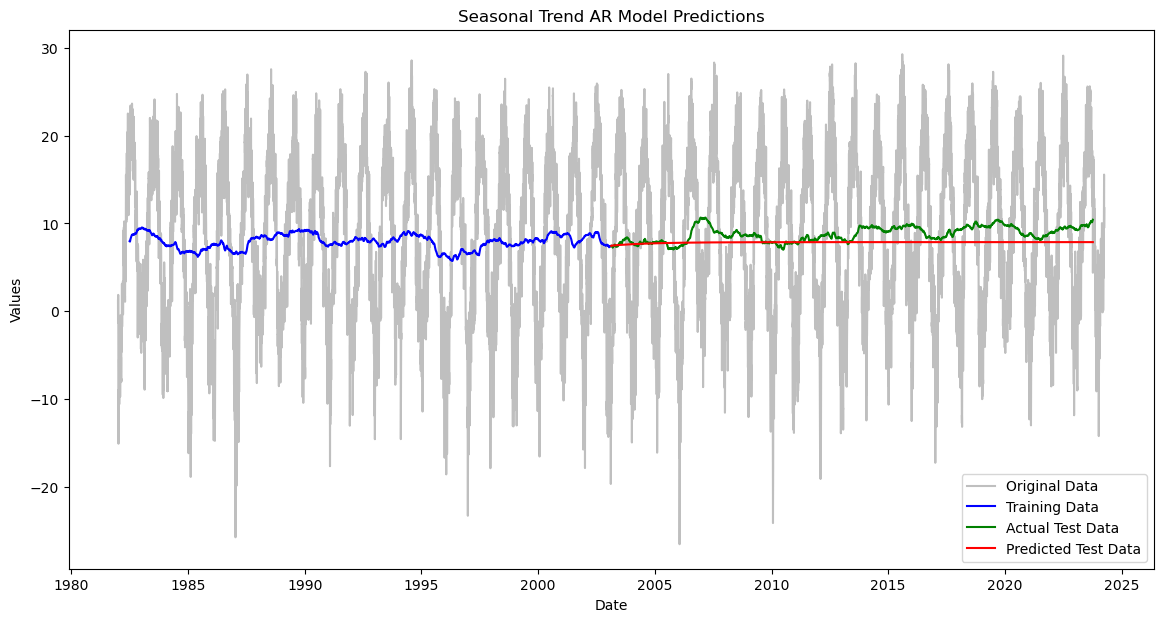

Mean Squared Error: 1.5564922491553643
Root Mean Squared Error: 1.2475945852541057


In [70]:
# Model AR dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_seasonal = best_ar_model(datasets_seasonal['train_50']['Trend_Seasonal'])
predictions_seasonal = plot_predictions(datasets_seasonal['train_50']['Trend_Seasonal'], datasets_seasonal['test_50']['Trend_Seasonal'], model_seasonal, data_xxx['T2M'], title='Seasonal Trend AR Model Predictions')
evaluate_forecast(datasets_seasonal['test_50']['Trend_Seasonal'], predictions_seasonal)

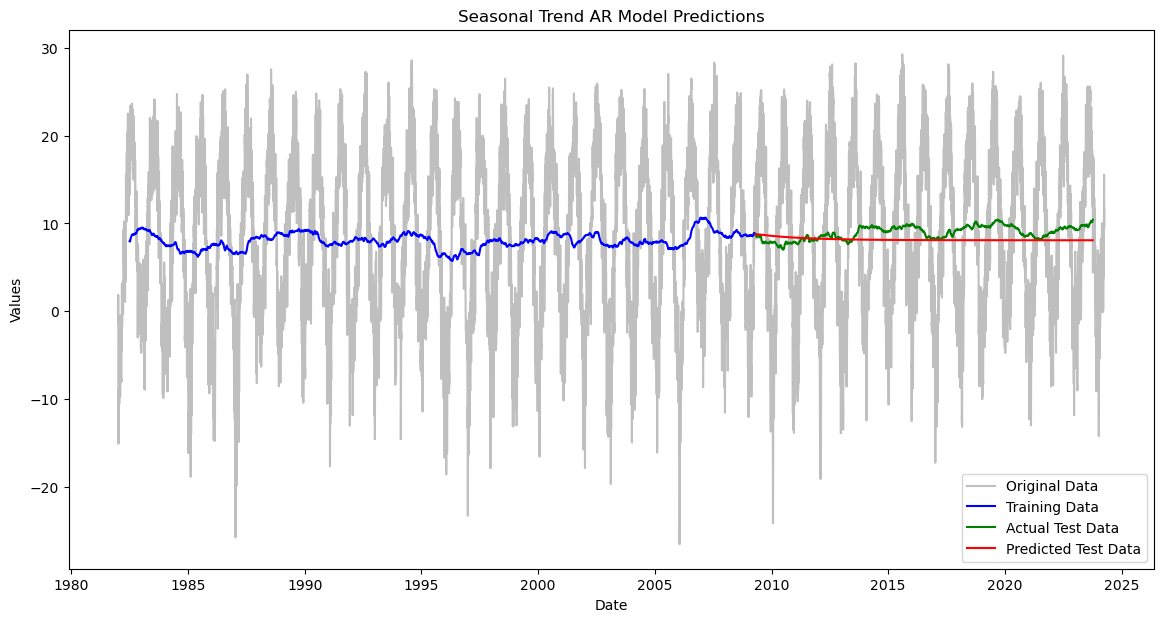

Mean Squared Error: 1.3363544922637813
Root Mean Squared Error: 1.1560079983563183


In [71]:
# Model AR dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_seasonal = best_ar_model(datasets_seasonal['train_65']['Trend_Seasonal'])
predictions_seasonal = plot_predictions(datasets_seasonal['train_65']['Trend_Seasonal'], datasets_seasonal['test_65']['Trend_Seasonal'], model_seasonal, data_xxx['T2M'], title='Seasonal Trend AR Model Predictions')
evaluate_forecast(datasets_seasonal['test_65']['Trend_Seasonal'], predictions_seasonal)

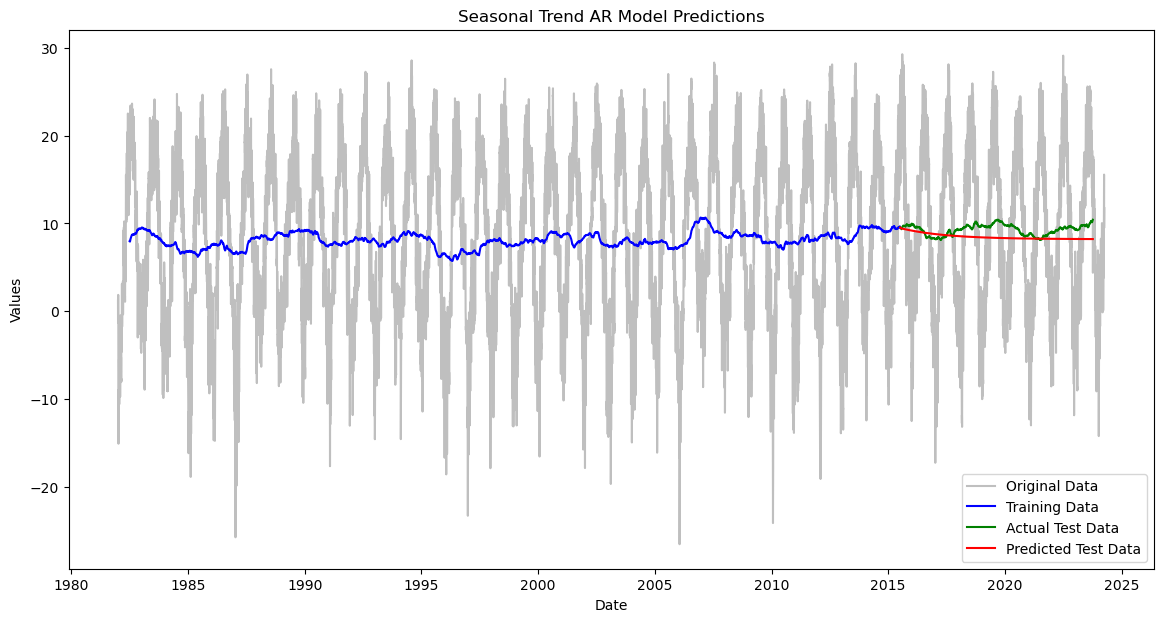

Mean Squared Error: 1.089048900020078
Root Mean Squared Error: 1.0435750572048366


In [72]:
# Model AR dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_seasonal = best_ar_model(datasets_seasonal['train_80']['Trend_Seasonal'])
predictions_seasonal = plot_predictions(datasets_seasonal['train_80']['Trend_Seasonal'], datasets_seasonal['test_80']['Trend_Seasonal'], model_seasonal, data_xxx['T2M'], title='Seasonal Trend AR Model Predictions')
evaluate_forecast(datasets_seasonal['test_80']['Trend_Seasonal'], predictions_seasonal)

Model MA

In [73]:
def evaluate_ma_model(data, max_lag):
    best_aic = float('inf')
    best_order = None
    best_model = None

    for q in range(1, max_lag + 1):
        try:
            model = ARIMA(data, order=(0, 0, q), enforce_stationarity=False, enforce_invertibility=True)
            results = model.fit(method='innovations_mle', low_memory=True)
            if results.aic < best_aic and np.all(np.abs(results.maparams) < 1):
                best_aic = results.aic
                best_order = q
                best_model = results
        except Exception as e:
            print(f"Failed to fit MA({q}) model: {e}")
            continue

    return best_order, best_aic, best_model


In [74]:
def plot_and_evaluate(train_data, test_data, model, original_data, title='MA Model Predictions'):
    # Generowanie przewidywań
    predictions = model.predict(start=test_data.index[0], end=test_data.index[-1])

    # Wizualizacja
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data, label='Original Data', color='grey', alpha=0.5)  # Dodane dane oryginalne
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    plt.plot(predictions.index, predictions, label='Predicted Test Data', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Obliczanie błędów
    mse = mean_squared_error(test_data, predictions)
    rmse = sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")


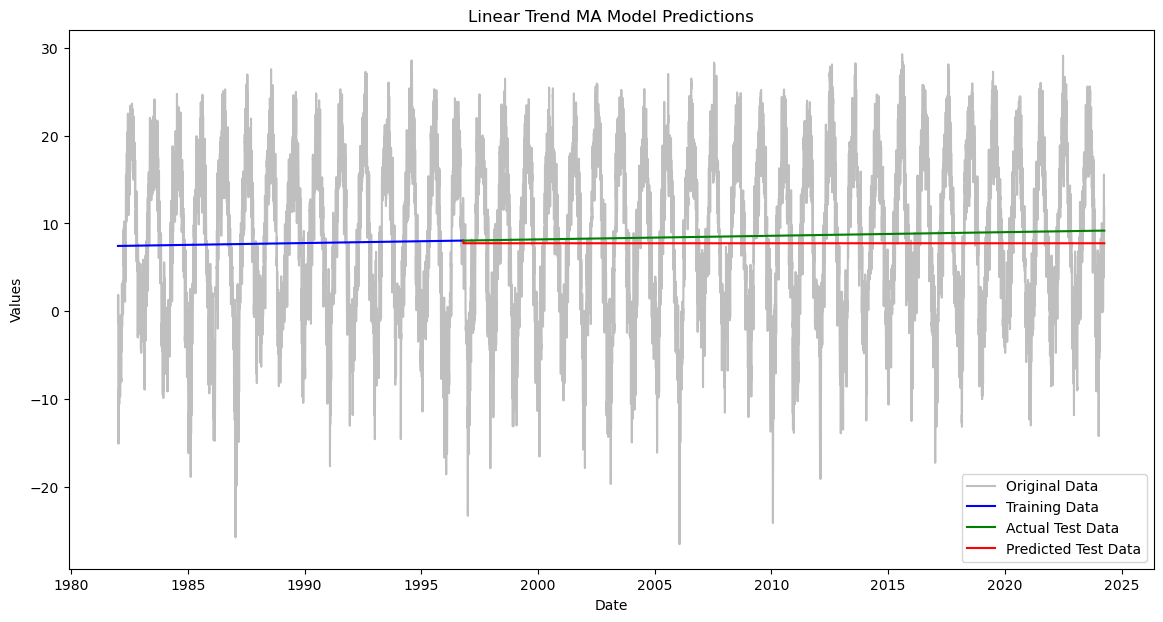

Mean Squared Error: 0.870693413877373
Root Mean Squared Error: 0.9331095401277242


In [75]:
# Dla danych liniowego trendu
order_lin, aic_lin, model_ma_lin = evaluate_ma_model(datasets_lin['train_35']['Trend_Linear'], max_lag=5)
if model_ma_lin is not None:
    plot_and_evaluate(datasets_lin['train_35']['Trend_Linear'], datasets_lin['test_35']['Trend_Linear'], model_ma_lin, data_xxx['T2M'], title='Linear Trend MA Model Predictions')

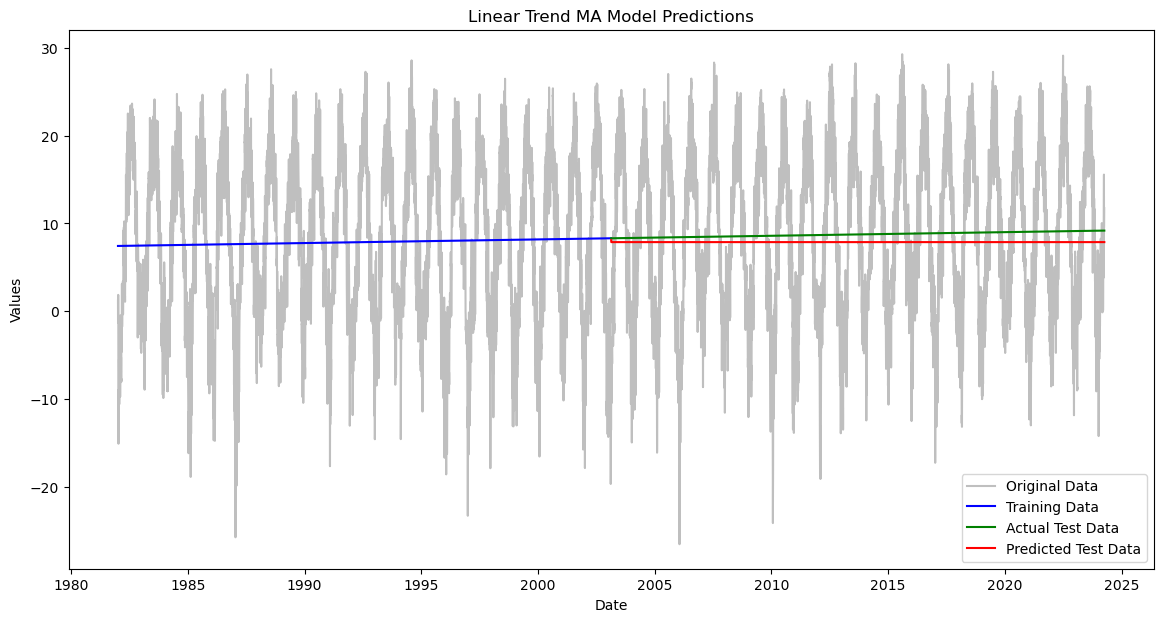

Mean Squared Error: 0.8267909313667295
Root Mean Squared Error: 0.9092804470386073


In [76]:
# Dla danych liniowego trendu
order_lin, aic_lin, model_ma_lin = evaluate_ma_model(datasets_lin['train_50']['Trend_Linear'], max_lag=5)
if model_ma_lin is not None:
    plot_and_evaluate(datasets_lin['train_50']['Trend_Linear'], datasets_lin['test_50']['Trend_Linear'], model_ma_lin, data_xxx['T2M'], title='Linear Trend MA Model Predictions')

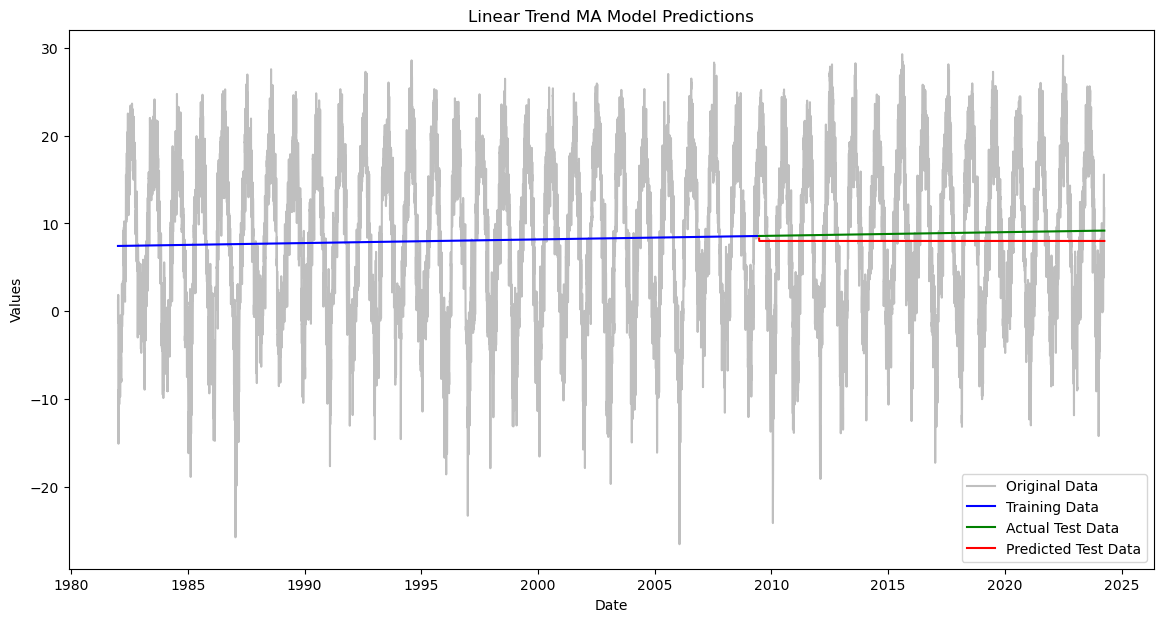

Mean Squared Error: 0.7943364263323517
Root Mean Squared Error: 0.8912555336896101


In [77]:
# Dla danych liniowego trendu
order_lin, aic_lin, model_ma_lin = evaluate_ma_model(datasets_lin['train_65']['Trend_Linear'], max_lag=5)
if model_ma_lin is not None:
    plot_and_evaluate(datasets_lin['train_65']['Trend_Linear'], datasets_lin['test_65']['Trend_Linear'], model_ma_lin, data_xxx['T2M'], title='Linear Trend MA Model Predictions')

Failed to fit MA(4) model: The model's autoregressive parameters (ar_params) indicate that the process
 is non-stationary. The innovations algorithm cannot be used.



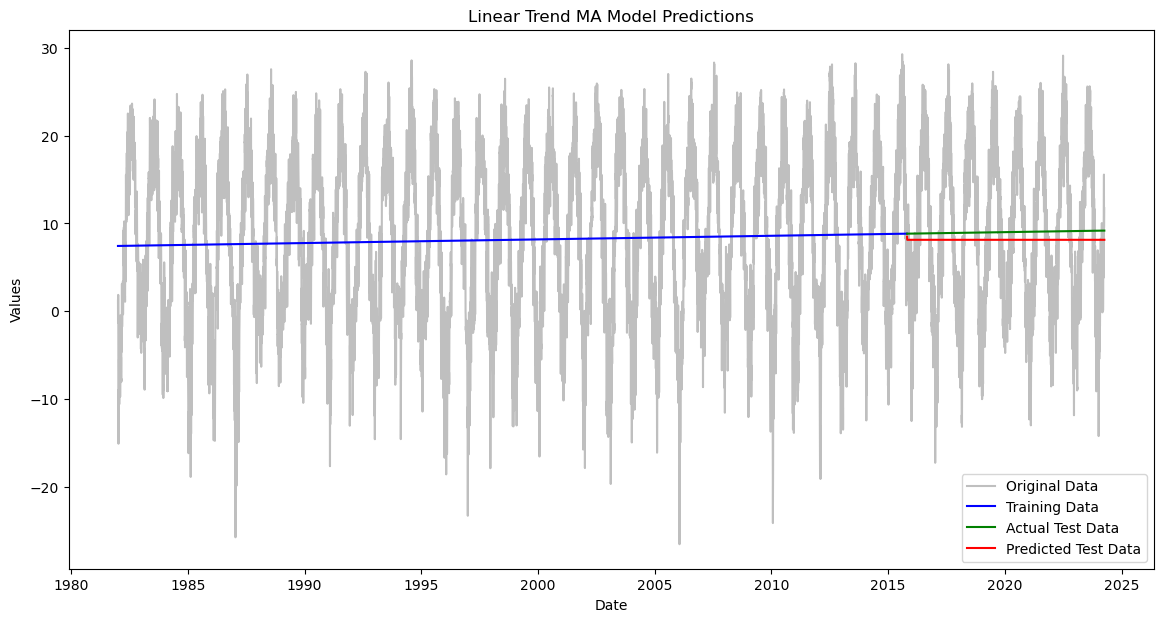

Mean Squared Error: 0.7732688578995776
Root Mean Squared Error: 0.8793570707622573


In [78]:
# Dla danych liniowego trendu
order_lin, aic_lin, model_ma_lin = evaluate_ma_model(datasets_lin['train_80']['Trend_Linear'], max_lag=5)
if model_ma_lin is not None:
    plot_and_evaluate(datasets_lin['train_80']['Trend_Linear'], datasets_lin['test_80']['Trend_Linear'], model_ma_lin, data_xxx['T2M'], title='Linear Trend MA Model Predictions')

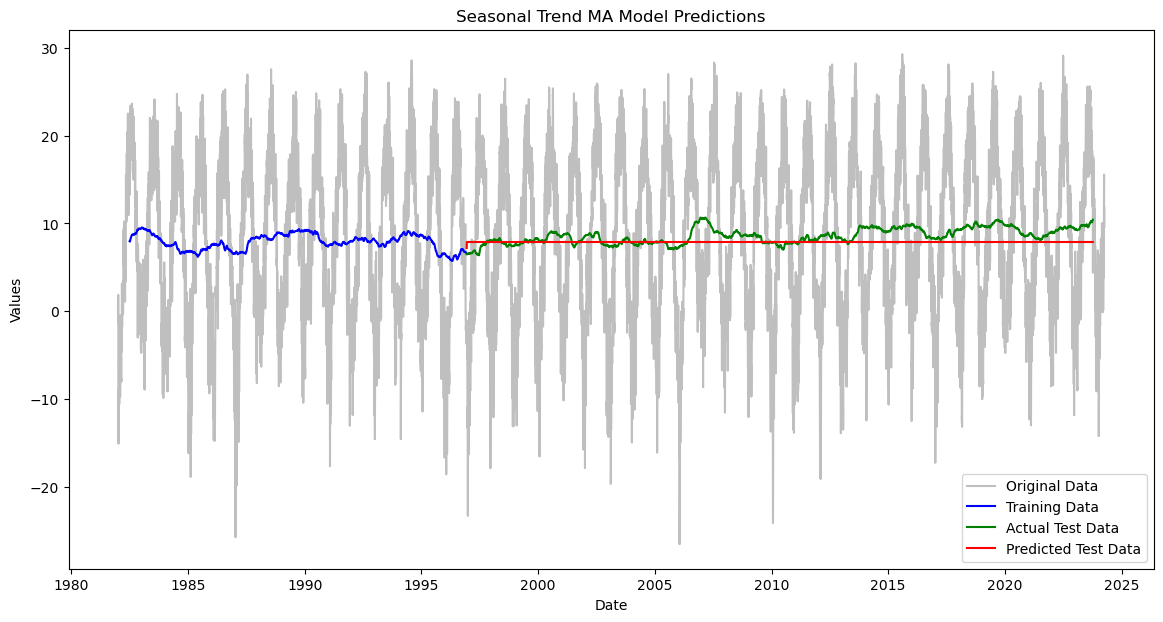

Mean Squared Error: 1.266309543569383
Root Mean Squared Error: 1.1253042004584284


In [79]:
# Dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_ma_seasonal = evaluate_ma_model(datasets_seasonal['train_35']['Trend_Seasonal'], max_lag=5)
if model_ma_seasonal is not None:
    plot_and_evaluate(datasets_seasonal['train_35']['Trend_Seasonal'], datasets_seasonal['test_35']['Trend_Seasonal'], model_ma_seasonal, data_xxx['T2M'], title='Seasonal Trend MA Model Predictions')

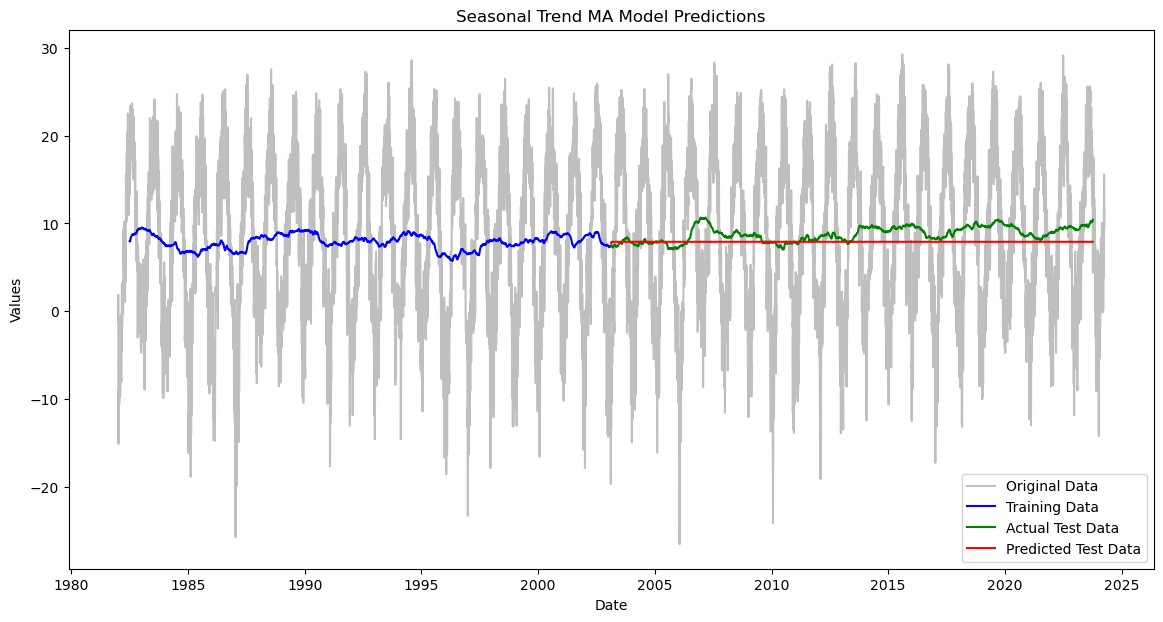

Mean Squared Error: 1.478387533626906
Root Mean Squared Error: 1.215889605855279


In [80]:
# Dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_ma_seasonal = evaluate_ma_model(datasets_seasonal['train_50']['Trend_Seasonal'], max_lag=5)
if model_ma_seasonal is not None:
    plot_and_evaluate(datasets_seasonal['train_50']['Trend_Seasonal'], datasets_seasonal['test_50']['Trend_Seasonal'], model_ma_seasonal, data_xxx['T2M'], title='Seasonal Trend MA Model Predictions')


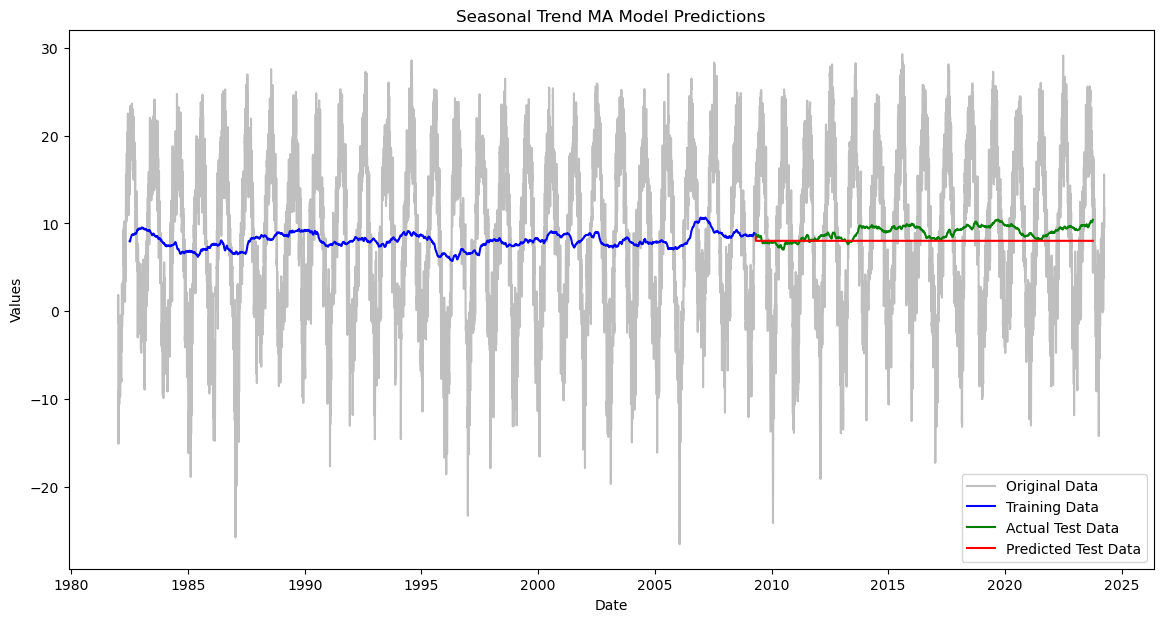

Mean Squared Error: 1.4330465100211085
Root Mean Squared Error: 1.1970992064240575


In [81]:
# Dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_ma_seasonal = evaluate_ma_model(datasets_seasonal['train_65']['Trend_Seasonal'], max_lag=5)
if model_ma_seasonal is not None:
    plot_and_evaluate(datasets_seasonal['train_65']['Trend_Seasonal'], datasets_seasonal['test_65']['Trend_Seasonal'], model_ma_seasonal, data_xxx['T2M'], title='Seasonal Trend MA Model Predictions')


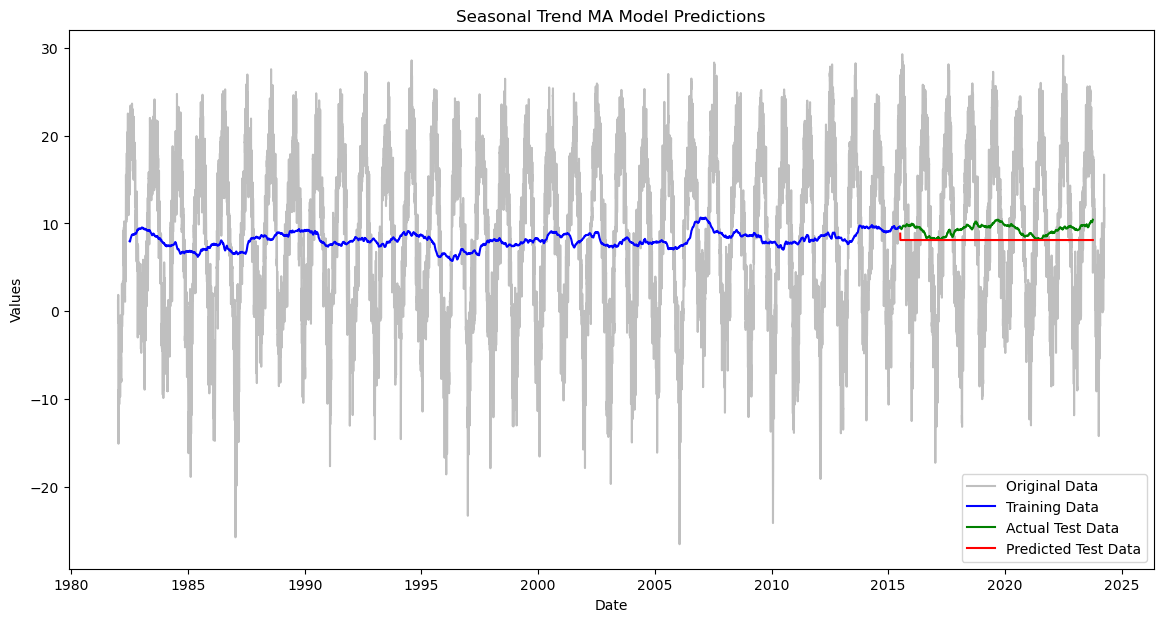

Mean Squared Error: 1.728645707648389
Root Mean Squared Error: 1.3147797182982361


In [82]:
# Dla danych sezonowego trendu
order_seasonal, aic_seasonal, model_ma_seasonal = evaluate_ma_model(datasets_seasonal['train_80']['Trend_Seasonal'], max_lag=5)
if model_ma_seasonal is not None:
    plot_and_evaluate(datasets_seasonal['train_80']['Trend_Seasonal'], datasets_seasonal['test_80']['Trend_Seasonal'], model_ma_seasonal, data_xxx['T2M'], title='Seasonal Trend MA Model Predictions')


Model ARIMA

In [83]:
def fit_and_plot_arima_with_original(train_data, test_data, original_data, title):
    # Dopasowanie modelu ARIMA z d zawsze równym 0
    arima_model = auto_arima(train_data, seasonal=False, trace=True, 
                             error_action='ignore', suppress_warnings=True, 
                             stepwise=True, d=0, max_p=3, max_q=3) # d=0 sprawia że dane nie są różnicowane ponieważ już są
                                                                   # stacjonarne. auto arima błednie próbowałe róznicować dane
    
    # Prognozowanie na podstawie modelu
    predictions = arima_model.predict(n_periods=len(test_data))
    test_index = test_data.index  # Zakładamy, że 'test_data' posiada prawidłowy indeks czasowy

    # Wizualizacja
    plt.figure(figsize=(14, 7))
    plt.plot(original_data.index, original_data, label='Original Data', color='grey', alpha=0.5)
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_index, test_data, label='Actual Test Data', color='green')
    plt.plot(test_index, predictions, label='Predicted Test Data', color='red')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    # Obliczenie MSE i RMSE
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=14.81 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=37456.395, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=4.35 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=4.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=7.81 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3403.749, Time=1.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-37539.295, Time=7.19 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=12.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-39362.960, Time=13.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-48242.351, Time=14.81 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-47899.062, Time=23.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-56251.190, Time=19.28 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-45499.408, Time=17.72 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=

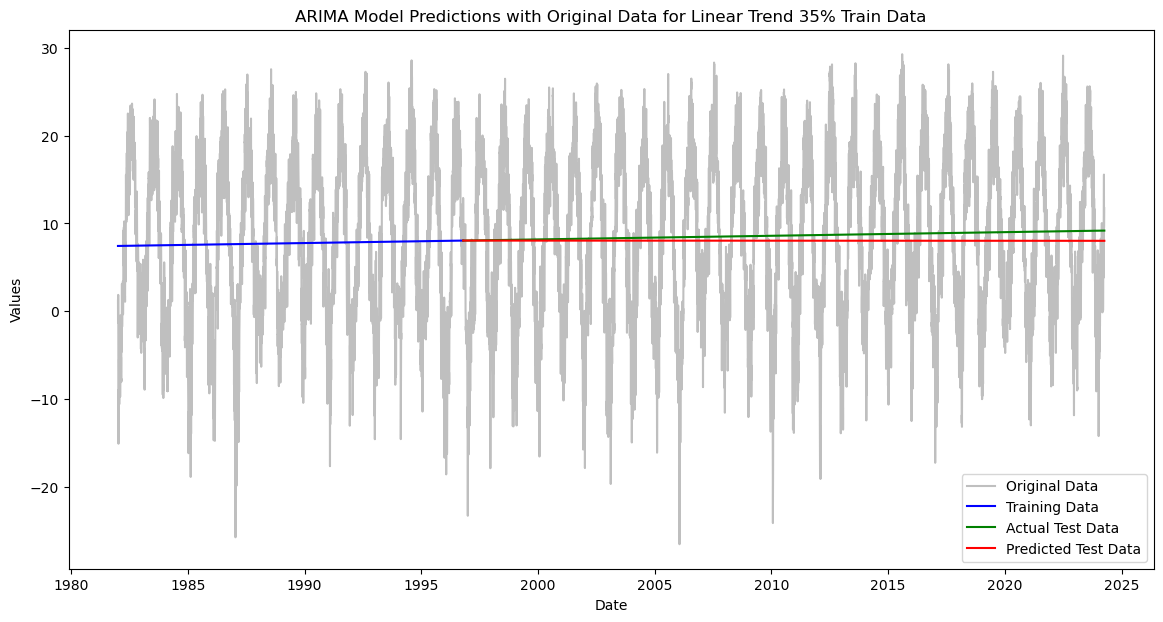

Mean Squared Error: 0.4506113426451247
Root Mean Squared Error: 0.6712759064983077


In [84]:
fit_and_plot_arima_with_original(
    train_data=datasets_lin['train_35']['Trend_Linear'],    # Dane treningowe dla trendu liniowego
    test_data=datasets_lin['test_35']['Trend_Linear'],      # Dane testowe dla trendu liniowego
    original_data=data_xxx['T2M'],                          # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Linear Trend 35% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=18.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=53774.251, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=6.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=6.75 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=10.74 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=642.722, Time=1.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-47359.269, Time=11.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=18.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-58423.620, Time=18.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=13.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-61012.865, Time=22.54 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-77937.351, Time=21.53 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=16.46 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-84438.800, Time=23.05 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-69115

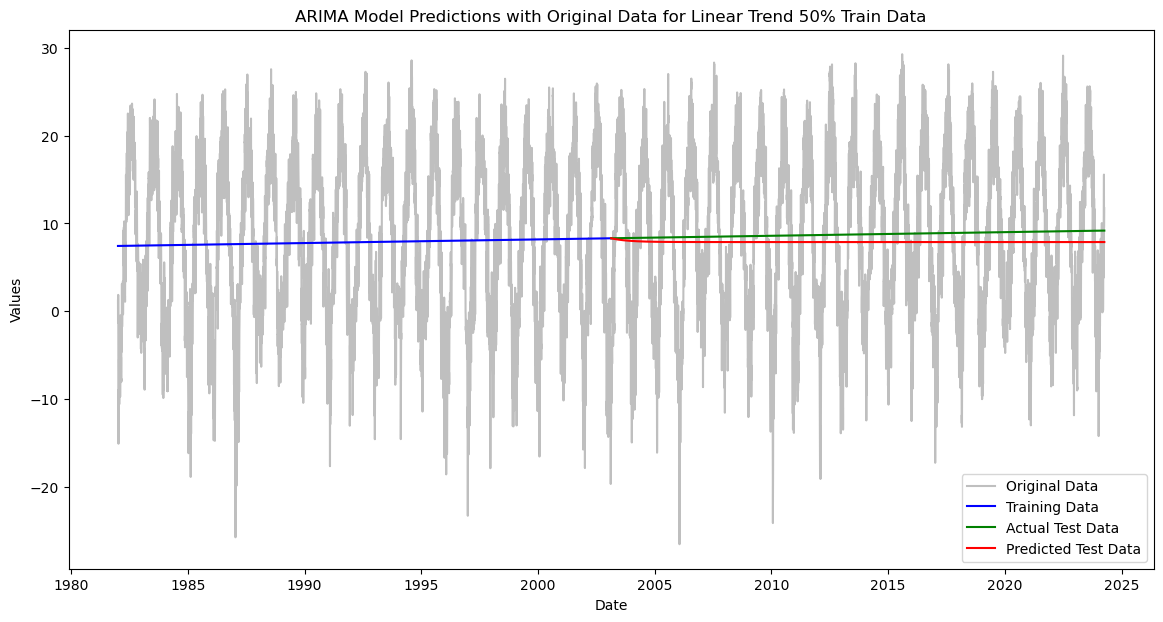

Mean Squared Error: 0.80673296217033
Root Mean Squared Error: 0.8981831451159223


In [85]:
fit_and_plot_arima_with_original(
    train_data=datasets_lin['train_50']['Trend_Linear'],    # Dane treningowe dla trendu liniowego
    test_data=datasets_lin['test_50']['Trend_Linear'],      # Dane testowe dla trendu liniowego
    original_data=data_xxx['T2M'],                          # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Linear Trend 50% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=13.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=70238.677, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=4.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.70 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=5.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6098.007, Time=1.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-52764.337, Time=7.79 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=16.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-64605.246, Time=14.78 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.63 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-81299.915, Time=19.94 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-102063.369, Time=24.64 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=21.45 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-109564.361, Time=28.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10160

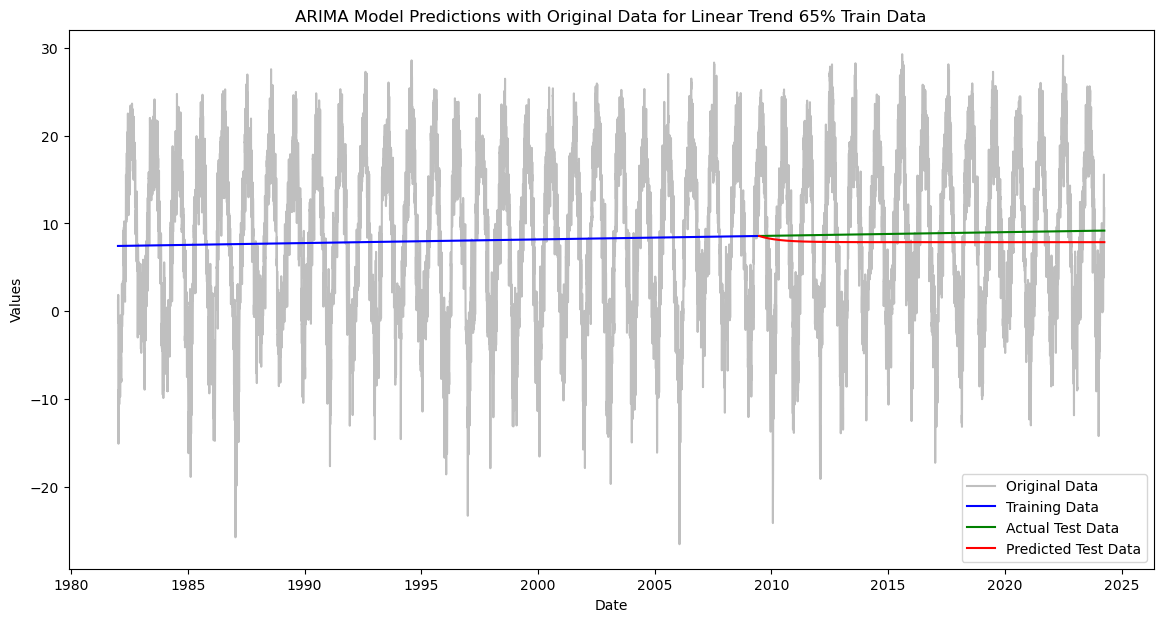

Mean Squared Error: 1.007654270448463
Root Mean Squared Error: 1.003819839636806


In [86]:
fit_and_plot_arima_with_original(
    train_data=datasets_lin['train_65']['Trend_Linear'],    # Dane treningowe dla trendu liniowego
    test_data=datasets_lin['test_65']['Trend_Linear'],      # Dane testowe dla trendu liniowego
    original_data=data_xxx['T2M'],                          # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Linear Trend 65% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=15.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=86861.095, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=5.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=4.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=6.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=12634.212, Time=1.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-61382.553, Time=9.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-76400.097, Time=18.99 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=26.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-100824.488, Time=23.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-85874.094, Time=19.96 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-117511.433, Time=29.73 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-119988.803, Time=34.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-127760.158, Time=28.71 sec
 ARIMA(1,0,2)(0,0,0)[0] interc

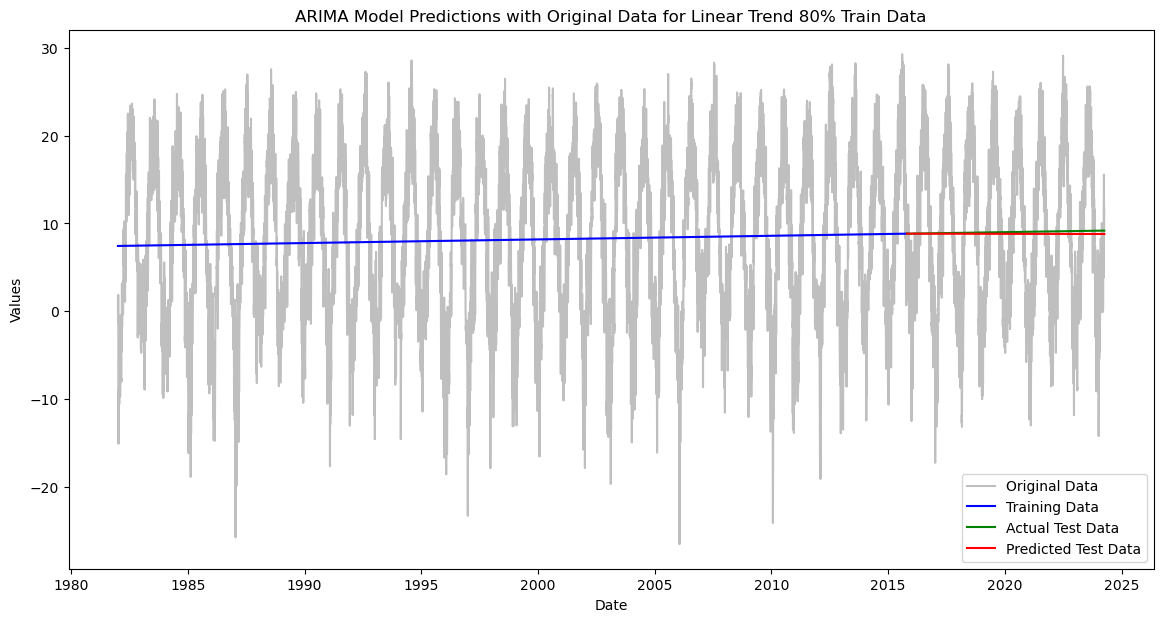

Mean Squared Error: 0.049561028631870625
Root Mean Squared Error: 0.22262306401599682


In [87]:
fit_and_plot_arima_with_original(
    train_data=datasets_lin['train_80']['Trend_Linear'],    # Dane treningowe dla trendu liniowego
    test_data=datasets_lin['test_80']['Trend_Linear'],      # Dane testowe dla trendu liniowego
    original_data=data_xxx['T2M'],                          # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Linear Trend 80% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-35860.138, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36828.294, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-34831.703, Time=1.95 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-35841.002, Time=0.84 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-35877.921, Time=1.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-35857.044, Time=2.55 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-35877.373, Time=0.89 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-35875.743, Time=1.05 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-35854.870, Time=7.77 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 18.733 seconds


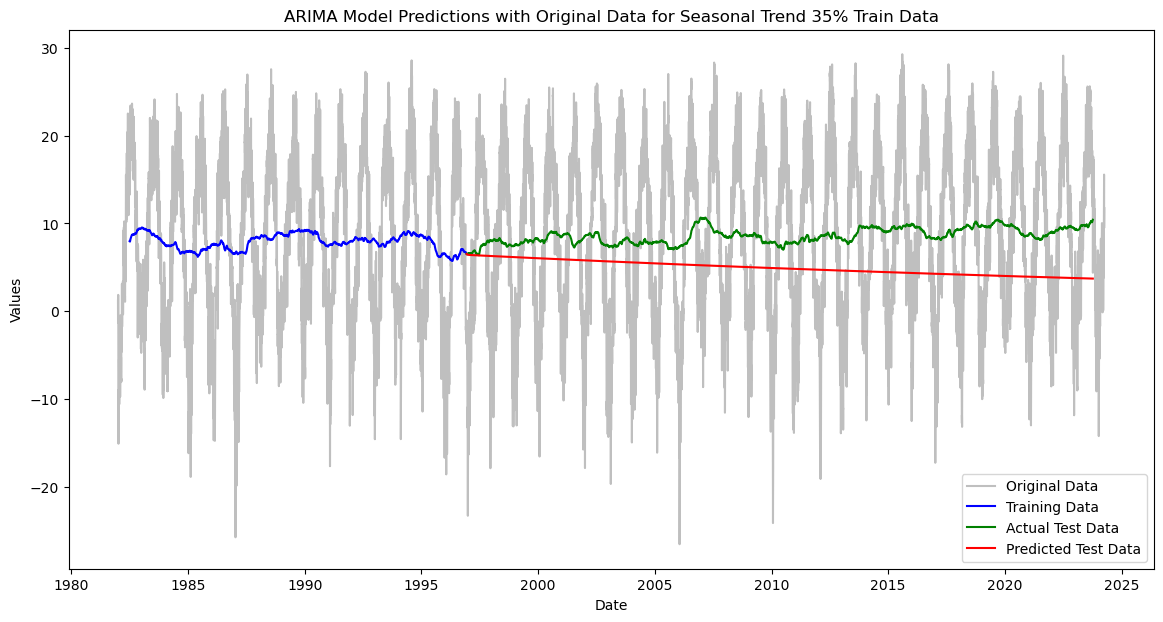

Mean Squared Error: 15.493683950049682
Root Mean Squared Error: 3.936201716128085


In [88]:
# Wywołanie funkcji dla sezonowego trendu i danych temperatury (oryginalne dane)
fit_and_plot_arima_with_original(
    train_data=datasets_seasonal['train_35']['Trend_Seasonal'],  # Dane treningowe dla trendu sezonowego
    test_data=datasets_seasonal['test_35']['Trend_Seasonal'],    # Dane testowe dla trendu sezonowego
    original_data=data_xxx['T2M'],                               # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Seasonal Trend 35% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-51218.616, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=52651.880, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-49808.233, Time=2.80 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-51205.692, Time=1.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-51241.446, Time=2.87 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-51047.043, Time=1.40 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-51255.137, Time=1.90 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-51245.722, Time=1.39 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-51250.548, Time=8.66 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 23.152 seconds


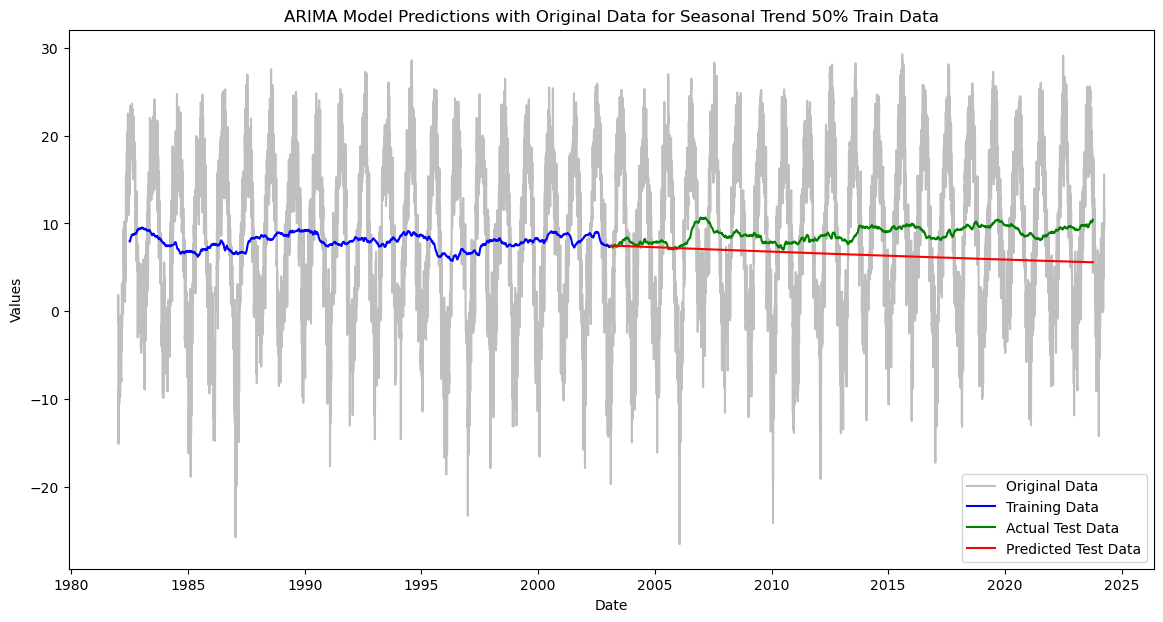

Mean Squared Error: 6.823675354658382
Root Mean Squared Error: 2.6122165596784623


In [89]:
# Wywołanie funkcji dla sezonowego trendu i danych temperatury (oryginalne dane)
fit_and_plot_arima_with_original(
    train_data=datasets_seasonal['train_50']['Trend_Seasonal'],  # Dane treningowe dla trendu sezonowego
    test_data=datasets_seasonal['test_50']['Trend_Seasonal'],    # Dane testowe dla trendu sezonowego
    original_data=data_xxx['T2M'],                               # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Seasonal Trend 50% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-66651.740, Time=1.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=68724.062, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=3.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-64823.505, Time=5.55 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-66632.611, Time=1.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-66689.871, Time=1.77 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-66442.288, Time=1.68 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-66697.289, Time=2.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-66688.928, Time=2.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-66701.764, Time=5.61 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-66699.486, Time=5.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-66017.957, Time=10.86 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-66661.323, Time=5.23 sec

Best model:  ARIMA

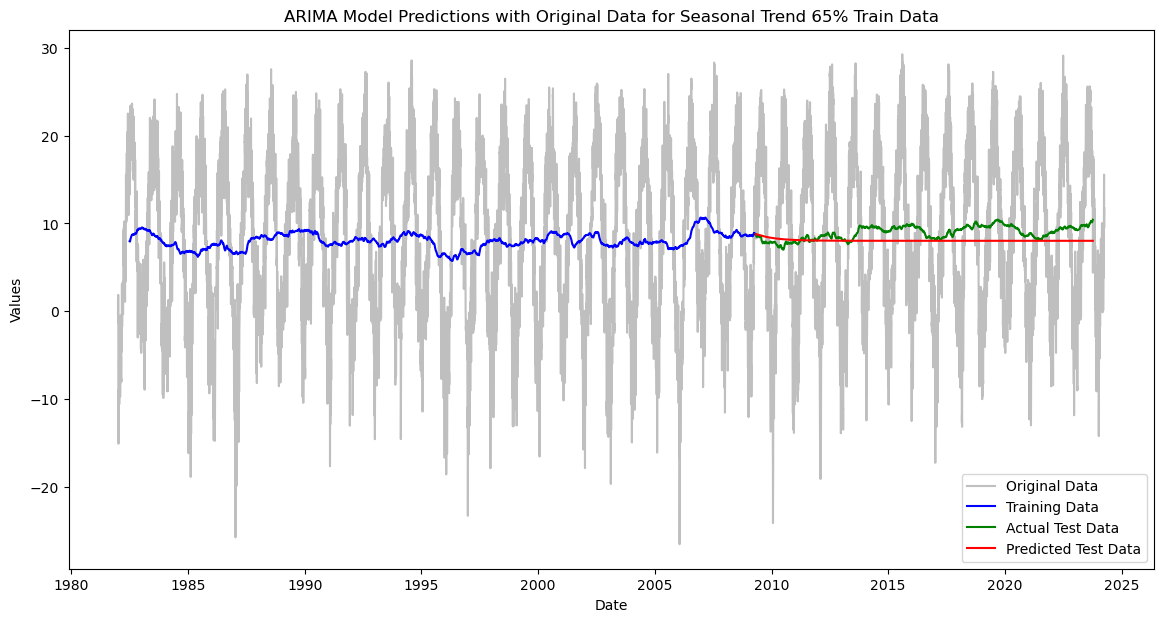

Mean Squared Error: 1.446188978447704
Root Mean Squared Error: 1.2025759761643768


In [90]:
# Wywołanie funkcji dla sezonowego trendu i danych temperatury (oryginalne dane)
fit_and_plot_arima_with_original(
    train_data=datasets_seasonal['train_65']['Trend_Seasonal'],  # Dane treningowe dla trendu sezonowego
    test_data=datasets_seasonal['test_65']['Trend_Seasonal'],    # Dane testowe dla trendu sezonowego
    original_data=data_xxx['T2M'],                               # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Seasonal Trend 65% Train Data'
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-76139.520, Time=7.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=84849.147, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=3.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-79666.292, Time=6.86 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=9.47 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-76129.593, Time=6.00 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-80800.454, Time=8.94 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=7.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-82082.044, Time=2.42 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-82091.434, Time=3.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-82087.689, Time=2.04 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-82092.617, Time=16.86 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-82094.583, Time=7.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept

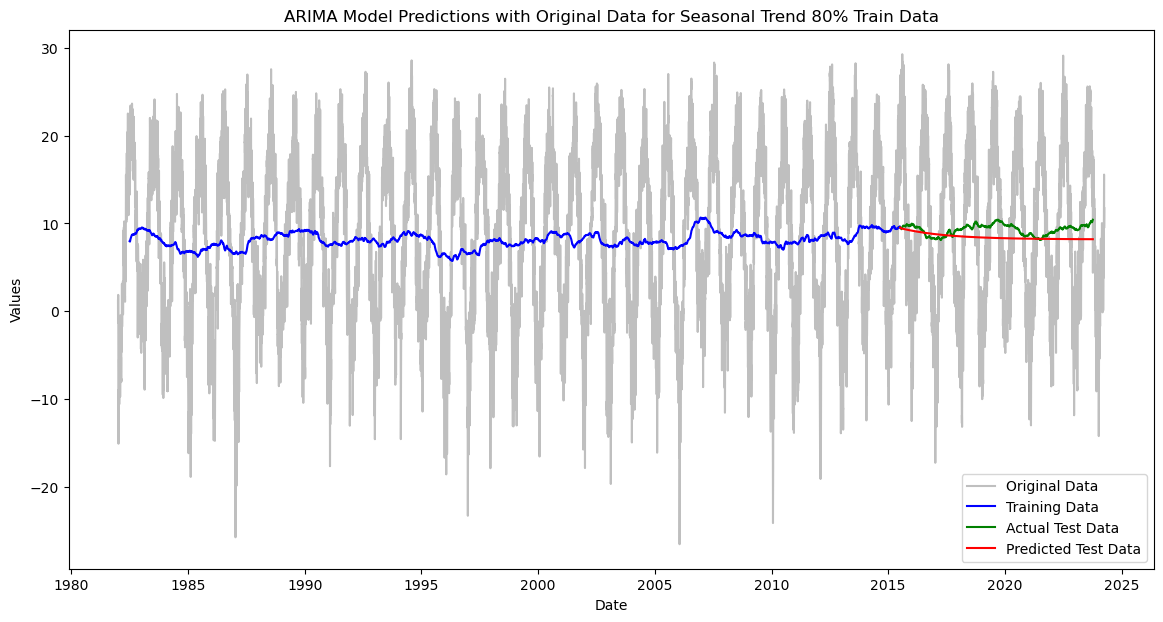

Mean Squared Error: 1.110330438047354
Root Mean Squared Error: 1.0537221825734495


In [91]:
# Wywołanie funkcji dla sezonowego trendu i danych temperatury (oryginalne dane)
fit_and_plot_arima_with_original(
    train_data=datasets_seasonal['train_80']['Trend_Seasonal'],  # Dane treningowe dla trendu sezonowego
    test_data=datasets_seasonal['test_80']['Trend_Seasonal'],    # Dane testowe dla trendu sezonowego
    original_data=data_xxx['T2M'],                               # Oryginalne dane temperatury
    title='ARIMA Model Predictions with Original Data for Seasonal Trend 80% Train Data'
)